In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
#FOLD=int(os.getenv("FOLD"))

In [3]:
FOLD=2

In [4]:
print FOLD

2


In [5]:
sys.path.insert(0,"../python/rrvf2017/")

In [6]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [7]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [8]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [9]:
gc.collect()

0

# cv

In [10]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [11]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [12]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [14]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [16]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [17]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [18]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        d_train = lgb.Dataset(trainX, label=trainy,categorical_feature=[0])
        d_valid = lgb.Dataset(validX, label=validy,categorical_feature=[0])
        
        if 1:
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': objective,
                'metric': {'rmse'},
                'num_leaves':num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'min_data_in_leaf': min_data_in_leaf,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
                'lambda_l2': lambda_l2,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'nthread': 8,
                'verbose': 0,
                'metric_freq': 50,
                'train_metric': True
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=1000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
            validpred=gbm.predict(validX,num_iteration=gbm.best_iteration)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(trainX,num_iteration=gbm.best_iteration)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [19]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [20]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX,num_iteration=model.best_iteration)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        pred=model.predict(X,num_iteration=model.best_iteration).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X,num_iteration=model.best_iteration)
    return pred,dataidx


In [21]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [22]:
EXCLUDE_HARD=True
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [23]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [24]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('3001eb_lgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (163101, 2) (40852, 2)
rand split across time
train has 163101 records out of 389630 records
valid has 40852 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1274
0
(163101, 1, 18) (163101, 7, 32) (163101, 1) (163101, 1)
(163101, 242) (163101,) (163101,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(5803, 1, 18) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 242) (5803,) (5803,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'b

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1030: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:671: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's rmse: 0.802937
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.782556
[3]	valid_0's rmse: 0.763232
[4]	valid_0's rmse: 0.745648
[5]	valid_0's rmse: 0.728885
[6]	valid_0's rmse: 0.713545
[7]	valid_0's rmse: 0.69968
[8]	valid_0's rmse: 0.686742
[9]	valid_0's rmse: 0.674667
[10]	valid_0's rmse: 0.663278
[11]	valid_0's rmse: 0.65326
[12]	valid_0's rmse: 0.64352
[13]	valid_0's rmse: 0.635023
[14]	valid_0's rmse: 0.626906
[15]	valid_0's rmse: 0.619507
[16]	valid_0's rmse: 0.61256
[17]	valid_0's rmse: 0.606417
[18]	valid_0's rmse: 0.60042
[19]	valid_0's rmse: 0.595109
[20]	valid_0's rmse: 0.590149
[21]	valid_0's rmse: 0.585606
[22]	valid_0's rmse: 0.581599
[23]	valid_0's rmse: 0.577955
[24]	valid_0's rmse: 0.574505
[25]	valid_0's rmse: 0.571456
[26]	valid_0's rmse: 0.568286
[27]	valid_0's rmse: 0.565609
[28]	valid_0's rmse: 0.563202
[29]	valid_0's rmse: 0.56087
[30]	valid_0's rmse: 0.558753
[31]	valid_0's rmse: 0.556914
[32]	valid_0's rmse: 0.

[268]	valid_0's rmse: 0.52416
[269]	valid_0's rmse: 0.524156
[270]	valid_0's rmse: 0.524167
[271]	valid_0's rmse: 0.524175
[272]	valid_0's rmse: 0.524166
[273]	valid_0's rmse: 0.524174
[274]	valid_0's rmse: 0.524179
[275]	valid_0's rmse: 0.524178
[276]	valid_0's rmse: 0.524175
[277]	valid_0's rmse: 0.524184
[278]	valid_0's rmse: 0.524186
[279]	valid_0's rmse: 0.524189
[280]	valid_0's rmse: 0.524175
[281]	valid_0's rmse: 0.524193
[282]	valid_0's rmse: 0.524175
[283]	valid_0's rmse: 0.524169
[284]	valid_0's rmse: 0.524164
[285]	valid_0's rmse: 0.524176
[286]	valid_0's rmse: 0.524165
[287]	valid_0's rmse: 0.524158
[288]	valid_0's rmse: 0.524156
[289]	valid_0's rmse: 0.524159
[290]	valid_0's rmse: 0.52415
[291]	valid_0's rmse: 0.524135
[292]	valid_0's rmse: 0.524131
[293]	valid_0's rmse: 0.524134
[294]	valid_0's rmse: 0.524138
[295]	valid_0's rmse: 0.524137
[296]	valid_0's rmse: 0.524126
[297]	valid_0's rmse: 0.524103
[298]	valid_0's rmse: 0.524112
[299]	valid_0's rmse: 0.524099
[300]	vali

[537]	valid_0's rmse: 0.523674
[538]	valid_0's rmse: 0.523673
[539]	valid_0's rmse: 0.523669
[540]	valid_0's rmse: 0.523658
[541]	valid_0's rmse: 0.523659
[542]	valid_0's rmse: 0.523662
[543]	valid_0's rmse: 0.523667
[544]	valid_0's rmse: 0.523678
[545]	valid_0's rmse: 0.52368
[546]	valid_0's rmse: 0.523663
[547]	valid_0's rmse: 0.523654
[548]	valid_0's rmse: 0.523657
[549]	valid_0's rmse: 0.52365
[550]	valid_0's rmse: 0.523641
Early stopping, best iteration is:
[500]	valid_0's rmse: 0.523623
0.058321181751457445 0.27418147776484253
[0.27418147776484253]
-1 mean score 0.27418147776484253
0.131908340163


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917836  0.011274  0.149384    7  2017-04-16
472     2.507290  2.528683 -0.021393  0.134720    1  2017-04-17
473     2.661330  2.665126 -0.003796  0.137169    2  2017-04-18
474     2.754815  2.757303 -0.002488  0.128513    3  2017-04-19
475     2.713762  2.715486 -0.001724  0.149438    4  2017-04-20
476     2.999000  2.998076  0.000924  0.102177    5  2017-04-21
477     3.075529  3.079799 -0.004270  0.121959    6  2017-04-22

0.131908340163


pred         y     error    error2  day        date
dayidx                                                         
471     2.917836  2.929110  0.011274  0.149384    7  2017-04-16
472     2.528683  2.507290 -0.021393  0.134720    1  2017-04-17
473     2.665126  2.661330 -0.003796  0.137169    2  2017-04-18
474     2.757303  2.754815 -0.002488  0.128513    3  2017-04-19
475     2.715486  2.713762 -0.001724  0.149438    4  2017-04-20
476     2.998076  2.999000  0.000924  0.102177    5  2017-04-21
477     3.079799  3.075529 -0.004270  0.121959    6  2017-04-22

(829, 242)


2
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (168405, 2) (42183, 2)
rand split across time
train has 168405 records out of 389630 records
valid has 42183 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1315
0
(168405, 1, 18) (168405, 7, 32) (168405, 1) (168405, 1)
(168405, 242) (168405,) (168405,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(6632, 1, 18) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 242) (6632,) (6632,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf'

[238]	valid_0's rmse: 0.517175
[239]	valid_0's rmse: 0.517159
[240]	valid_0's rmse: 0.51715
[241]	valid_0's rmse: 0.517138
[242]	valid_0's rmse: 0.517124
[243]	valid_0's rmse: 0.517127
[244]	valid_0's rmse: 0.517104
[245]	valid_0's rmse: 0.51709
[246]	valid_0's rmse: 0.517077
[247]	valid_0's rmse: 0.517052
[248]	valid_0's rmse: 0.517036
[249]	valid_0's rmse: 0.517019
[250]	valid_0's rmse: 0.516999
[251]	valid_0's rmse: 0.516994
[252]	valid_0's rmse: 0.51699
[253]	valid_0's rmse: 0.51699
[254]	valid_0's rmse: 0.516993
[255]	valid_0's rmse: 0.516973
[256]	valid_0's rmse: 0.516982
[257]	valid_0's rmse: 0.51698
[258]	valid_0's rmse: 0.516986
[259]	valid_0's rmse: 0.51697
[260]	valid_0's rmse: 0.516971
[261]	valid_0's rmse: 0.516963
[262]	valid_0's rmse: 0.516954
[263]	valid_0's rmse: 0.516965
[264]	valid_0's rmse: 0.516964
[265]	valid_0's rmse: 0.516965
[266]	valid_0's rmse: 0.51696
[267]	valid_0's rmse: 0.516949
[268]	valid_0's rmse: 0.516934
[269]	valid_0's rmse: 0.516942
[270]	valid_0's

[504]	valid_0's rmse: 0.516314
[505]	valid_0's rmse: 0.516312
[506]	valid_0's rmse: 0.516304
[507]	valid_0's rmse: 0.516312
[508]	valid_0's rmse: 0.516321
[509]	valid_0's rmse: 0.516325
[510]	valid_0's rmse: 0.51632
[511]	valid_0's rmse: 0.516321
[512]	valid_0's rmse: 0.516326
[513]	valid_0's rmse: 0.516314
[514]	valid_0's rmse: 0.516313
[515]	valid_0's rmse: 0.516312
[516]	valid_0's rmse: 0.516311
[517]	valid_0's rmse: 0.516311
[518]	valid_0's rmse: 0.516293
[519]	valid_0's rmse: 0.516296
[520]	valid_0's rmse: 0.516301
[521]	valid_0's rmse: 0.5163
[522]	valid_0's rmse: 0.516302
[523]	valid_0's rmse: 0.516312
[524]	valid_0's rmse: 0.516323
[525]	valid_0's rmse: 0.516327
[526]	valid_0's rmse: 0.51632
[527]	valid_0's rmse: 0.51632
[528]	valid_0's rmse: 0.516323
[529]	valid_0's rmse: 0.516334
[530]	valid_0's rmse: 0.516343
[531]	valid_0's rmse: 0.516329
[532]	valid_0's rmse: 0.516328
[533]	valid_0's rmse: 0.516313
[534]	valid_0's rmse: 0.516307
[535]	valid_0's rmse: 0.516312
[536]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918882  0.010228  0.148315    7  2017-04-16
472     2.507290  2.538095 -0.030804  0.163894    1  2017-04-17
473     2.661330  2.677341 -0.016011  0.163426    2  2017-04-18
474     2.754815  2.746210  0.008605  0.127508    3  2017-04-19
475     2.713762  2.715399 -0.001637  0.154508    4  2017-04-20
476     2.999000  2.993989  0.005011  0.102934    5  2017-04-21
477     3.075529  3.076517 -0.000988  0.108331    6  2017-04-22

0.138416633573


pred         y     error    error2  day        date
dayidx                                                         
471     2.918882  2.929110  0.010228  0.148315    7  2017-04-16
472     2.538095  2.507290 -0.030804  0.163894    1  2017-04-17
473     2.677341  2.661330 -0.016011  0.163426    2  2017-04-18
474     2.746210  2.754815  0.008605  0.127508    3  2017-04-19
475     2.715399  2.713762 -0.001637  0.154508    4  2017-04-20
476     2.993989  2.999000  0.005011  0.102934    5  2017-04-21
477     3.076517  3.075529 -0.000988  0.108331    6  2017-04-22

(829, 242)


3
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (168897, 2) (42273, 2)
rand split across time
train has 168897 records out of 389630 records
valid has 42273 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1319
0
(168897, 1, 18) (168897, 7, 32) (168897, 1) (168897, 1)
(168897, 242) (168897,) (168897,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(7461, 1, 18) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 242) (7461,) (7461,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf'

[236]	valid_0's rmse: 0.521585
[237]	valid_0's rmse: 0.521588
[238]	valid_0's rmse: 0.521582
[239]	valid_0's rmse: 0.521581
[240]	valid_0's rmse: 0.521577
[241]	valid_0's rmse: 0.521562
[242]	valid_0's rmse: 0.521551
[243]	valid_0's rmse: 0.521543
[244]	valid_0's rmse: 0.521513
[245]	valid_0's rmse: 0.521515
[246]	valid_0's rmse: 0.5215
[247]	valid_0's rmse: 0.521492
[248]	valid_0's rmse: 0.521468
[249]	valid_0's rmse: 0.521465
[250]	valid_0's rmse: 0.521453
[251]	valid_0's rmse: 0.521418
[252]	valid_0's rmse: 0.521411
[253]	valid_0's rmse: 0.521396
[254]	valid_0's rmse: 0.521408
[255]	valid_0's rmse: 0.521398
[256]	valid_0's rmse: 0.521404
[257]	valid_0's rmse: 0.521373
[258]	valid_0's rmse: 0.521382
[259]	valid_0's rmse: 0.521393
[260]	valid_0's rmse: 0.521376
[261]	valid_0's rmse: 0.521368
[262]	valid_0's rmse: 0.521357
[263]	valid_0's rmse: 0.521347
[264]	valid_0's rmse: 0.521344
[265]	valid_0's rmse: 0.521333
[266]	valid_0's rmse: 0.521339
[267]	valid_0's rmse: 0.521341
[268]	vali

[506]	valid_0's rmse: 0.520611
[507]	valid_0's rmse: 0.520595
[508]	valid_0's rmse: 0.520606
[509]	valid_0's rmse: 0.520609
[510]	valid_0's rmse: 0.520613
[511]	valid_0's rmse: 0.520619
[512]	valid_0's rmse: 0.520626
[513]	valid_0's rmse: 0.52062
[514]	valid_0's rmse: 0.520623
[515]	valid_0's rmse: 0.520629
[516]	valid_0's rmse: 0.520631
[517]	valid_0's rmse: 0.520636
[518]	valid_0's rmse: 0.520633
[519]	valid_0's rmse: 0.520635
[520]	valid_0's rmse: 0.520636
[521]	valid_0's rmse: 0.520643
[522]	valid_0's rmse: 0.520655
[523]	valid_0's rmse: 0.520662
[524]	valid_0's rmse: 0.520662
[525]	valid_0's rmse: 0.520665
[526]	valid_0's rmse: 0.520669
[527]	valid_0's rmse: 0.520663
[528]	valid_0's rmse: 0.520659
[529]	valid_0's rmse: 0.520668
[530]	valid_0's rmse: 0.520661
[531]	valid_0's rmse: 0.520661
[532]	valid_0's rmse: 0.52066
[533]	valid_0's rmse: 0.520662
[534]	valid_0's rmse: 0.520656
[535]	valid_0's rmse: 0.520658
[536]	valid_0's rmse: 0.520654
[537]	valid_0's rmse: 0.520651
[538]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913611  0.015499  0.153219    7  2017-04-16
472     2.507290  2.534761 -0.027470  0.144537    1  2017-04-17
473     2.661330  2.669413 -0.008083  0.171583    2  2017-04-18
474     2.754815  2.781703 -0.026888  0.158598    3  2017-04-19
475     2.713762  2.722251 -0.008489  0.154405    4  2017-04-20
476     2.999000  2.999292 -0.000292  0.105536    5  2017-04-21
477     3.075529  3.080431 -0.004902  0.119612    6  2017-04-22

0.143927103384


pred         y     error    error2  day        date
dayidx                                                         
471     2.913611  2.929110  0.015499  0.153219    7  2017-04-16
472     2.534761  2.507290 -0.027470  0.144537    1  2017-04-17
473     2.669413  2.661330 -0.008083  0.171583    2  2017-04-18
474     2.781703  2.754815 -0.026888  0.158598    3  2017-04-19
475     2.722251  2.713762 -0.008489  0.154405    4  2017-04-20
476     2.999292  2.999000 -0.000292  0.105536    5  2017-04-21
477     3.080431  3.075529 -0.004902  0.119612    6  2017-04-22

(829, 242)


4
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (168960, 2) (42335, 2)
rand split across time
train has 168960 records out of 389630 records
valid has 42335 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1320
0
(168960, 1, 18) (168960, 7, 32) (168960, 1) (168960, 1)
(168960, 242) (168960,) (168960,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(8290, 1, 18) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 242) (8290,) (8290,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf'

[238]	valid_0's rmse: 0.521643
[239]	valid_0's rmse: 0.521632
[240]	valid_0's rmse: 0.521627
[241]	valid_0's rmse: 0.521614
[242]	valid_0's rmse: 0.5216
[243]	valid_0's rmse: 0.521595
[244]	valid_0's rmse: 0.521562
[245]	valid_0's rmse: 0.521552
[246]	valid_0's rmse: 0.521554
[247]	valid_0's rmse: 0.521544
[248]	valid_0's rmse: 0.521551
[249]	valid_0's rmse: 0.521561
[250]	valid_0's rmse: 0.521539
[251]	valid_0's rmse: 0.521528
[252]	valid_0's rmse: 0.5215
[253]	valid_0's rmse: 0.521477
[254]	valid_0's rmse: 0.521464
[255]	valid_0's rmse: 0.521457
[256]	valid_0's rmse: 0.521449
[257]	valid_0's rmse: 0.521461
[258]	valid_0's rmse: 0.521457
[259]	valid_0's rmse: 0.521463
[260]	valid_0's rmse: 0.521464
[261]	valid_0's rmse: 0.521456
[262]	valid_0's rmse: 0.521451
[263]	valid_0's rmse: 0.521441
[264]	valid_0's rmse: 0.521456
[265]	valid_0's rmse: 0.521446
[266]	valid_0's rmse: 0.521424
[267]	valid_0's rmse: 0.521406
[268]	valid_0's rmse: 0.521402
[269]	valid_0's rmse: 0.521405
[270]	valid_

[505]	valid_0's rmse: 0.521048
[506]	valid_0's rmse: 0.52104
[507]	valid_0's rmse: 0.52103
[508]	valid_0's rmse: 0.521023
[509]	valid_0's rmse: 0.521021
[510]	valid_0's rmse: 0.521027
[511]	valid_0's rmse: 0.521017
Early stopping, best iteration is:
[461]	valid_0's rmse: 0.521001
0.059091044445746546 0.27144219041161266
[0.27144219041161266]
-1 mean score 0.27144219041161266
0.14702876448


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902669  0.026441  0.163223    7  2017-04-16
472     2.507290  2.535842 -0.028552  0.145575    1  2017-04-17
473     2.661330  2.666639 -0.005309  0.164732    2  2017-04-18
474     2.754815  2.752432  0.002383  0.147080    3  2017-04-19
475     2.713762  2.711221  0.002541  0.171233    4  2017-04-20
476     2.999000  2.994981  0.004018  0.109003    5  2017-04-21
477     3.075529  3.069615  0.005914  0.128357    6  2017-04-22

0.14702876448


pred         y     error    error2  day        date
dayidx                                                         
471     2.902669  2.929110  0.026441  0.163223    7  2017-04-16
472     2.535842  2.507290 -0.028552  0.145575    1  2017-04-17
473     2.666639  2.661330 -0.005309  0.164732    2  2017-04-18
474     2.752432  2.754815  0.002383  0.147080    3  2017-04-19
475     2.711221  2.713762  0.002541  0.171233    4  2017-04-20
476     2.994981  2.999000  0.004018  0.109003    5  2017-04-21
477     3.069615  3.075529  0.005914  0.128357    6  2017-04-22

(829, 242)


5
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (169090, 2) (42402, 2)
rand split across time
train has 169090 records out of 389630 records
valid has 42402 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1321
0
(169090, 1, 18) (169090, 7, 32) (169090, 1) (169090, 1)
(169090, 242) (169090,) (169090,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(9119, 1, 18) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 242) (9119,) (9119,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf'

[237]	valid_0's rmse: 0.521501
[238]	valid_0's rmse: 0.521494
[239]	valid_0's rmse: 0.521461
[240]	valid_0's rmse: 0.52145
[241]	valid_0's rmse: 0.521455
[242]	valid_0's rmse: 0.521463
[243]	valid_0's rmse: 0.521457
[244]	valid_0's rmse: 0.52146
[245]	valid_0's rmse: 0.521464
[246]	valid_0's rmse: 0.521463
[247]	valid_0's rmse: 0.521464
[248]	valid_0's rmse: 0.52146
[249]	valid_0's rmse: 0.521451
[250]	valid_0's rmse: 0.521443
[251]	valid_0's rmse: 0.521411
[252]	valid_0's rmse: 0.521406
[253]	valid_0's rmse: 0.5214
[254]	valid_0's rmse: 0.521361
[255]	valid_0's rmse: 0.521371
[256]	valid_0's rmse: 0.521349
[257]	valid_0's rmse: 0.521353
[258]	valid_0's rmse: 0.521356
[259]	valid_0's rmse: 0.52136
[260]	valid_0's rmse: 0.521359
[261]	valid_0's rmse: 0.521341
[262]	valid_0's rmse: 0.521347
[263]	valid_0's rmse: 0.521355
[264]	valid_0's rmse: 0.521334
[265]	valid_0's rmse: 0.521324
[266]	valid_0's rmse: 0.52133
[267]	valid_0's rmse: 0.521355
[268]	valid_0's rmse: 0.521356
[269]	valid_0's

[504]	valid_0's rmse: 0.521122
[505]	valid_0's rmse: 0.521106
[506]	valid_0's rmse: 0.521105
[507]	valid_0's rmse: 0.521117
Early stopping, best iteration is:
[457]	valid_0's rmse: 0.521052
0.059443014705462975 0.2714952958349019
[0.2714952958349019]
-1 mean score 0.2714952958349019
0.146945636816


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913888  0.015222  0.166872    7  2017-04-16
472     2.507290  2.536152 -0.028861  0.147992    1  2017-04-17
473     2.661330  2.662113 -0.000783  0.152737    2  2017-04-18
474     2.754815  2.766779 -0.011964  0.145400    3  2017-04-19
475     2.713762  2.729411 -0.015649  0.172471    4  2017-04-20
476     2.999000  2.997011  0.001988  0.120118    5  2017-04-21
477     3.075529  3.067714  0.007815  0.123030    6  2017-04-22

0.146945636816


pred         y     error    error2  day        date
dayidx                                                         
471     2.913888  2.929110  0.015222  0.166872    7  2017-04-16
472     2.536152  2.507290 -0.028861  0.147992    1  2017-04-17
473     2.662113  2.661330 -0.000783  0.152737    2  2017-04-18
474     2.766779  2.754815 -0.011964  0.145400    3  2017-04-19
475     2.729411  2.713762 -0.015649  0.172471    4  2017-04-20
476     2.997011  2.999000  0.001988  0.120118    5  2017-04-21
477     3.067714  3.075529  0.007815  0.123030    6  2017-04-22

(829, 242)


6
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 15.133374
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (169020, 2) (42397, 2)
rand split across time
train has 169020 records out of 389630 records
valid has 42397 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1320
0
(169020, 1, 18) (169020, 7, 32) (169020, 1) (169020, 1)
(169020, 242) (169020,) (169020,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(9948, 1, 18) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 242) (9948,) (9948,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf'

[239]	valid_0's rmse: 0.524642
[240]	valid_0's rmse: 0.524629
[241]	valid_0's rmse: 0.524621
[242]	valid_0's rmse: 0.524616
[243]	valid_0's rmse: 0.524602
[244]	valid_0's rmse: 0.524611
[245]	valid_0's rmse: 0.524598
[246]	valid_0's rmse: 0.524597
[247]	valid_0's rmse: 0.524575
[248]	valid_0's rmse: 0.524588
[249]	valid_0's rmse: 0.524572
[250]	valid_0's rmse: 0.524555
[251]	valid_0's rmse: 0.524536
[252]	valid_0's rmse: 0.524523
[253]	valid_0's rmse: 0.524524
[254]	valid_0's rmse: 0.524502
[255]	valid_0's rmse: 0.524513
[256]	valid_0's rmse: 0.524499
[257]	valid_0's rmse: 0.524504
[258]	valid_0's rmse: 0.524499
[259]	valid_0's rmse: 0.524496
[260]	valid_0's rmse: 0.524489
[261]	valid_0's rmse: 0.524494
[262]	valid_0's rmse: 0.524476
[263]	valid_0's rmse: 0.524466
[264]	valid_0's rmse: 0.524464
[265]	valid_0's rmse: 0.524461
[266]	valid_0's rmse: 0.524458
[267]	valid_0's rmse: 0.524461
[268]	valid_0's rmse: 0.524465
[269]	valid_0's rmse: 0.52447
[270]	valid_0's rmse: 0.524472
[271]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917436  0.011674  0.180789    7  2017-04-16
472     2.507290  2.535398 -0.028107  0.166040    1  2017-04-17
473     2.661330  2.657452  0.003878  0.176009    2  2017-04-18
474     2.754815  2.757892 -0.003077  0.145817    3  2017-04-19
475     2.713762  2.718402 -0.004640  0.167069    4  2017-04-20
476     2.999000  2.980181  0.018819  0.121094    5  2017-04-21
477     3.075529  3.092036 -0.016507  0.140478    6  2017-04-22

0.156756461333


pred         y     error    error2  day        date
dayidx                                                         
471     2.917436  2.929110  0.011674  0.180789    7  2017-04-16
472     2.535398  2.507290 -0.028107  0.166040    1  2017-04-17
473     2.657452  2.661330  0.003878  0.176009    2  2017-04-18
474     2.757892  2.754815 -0.003077  0.145817    3  2017-04-19
475     2.718402  2.713762 -0.004640  0.167069    4  2017-04-20
476     2.980181  2.999000  0.018819  0.121094    5  2017-04-21
477     3.092036  3.075529 -0.016507  0.140478    6  2017-04-22

(829, 242)


7
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 16.310143
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (169426, 2) (42459, 2)
rand split across time
train has 169426 records out of 389630 records
valid has 42459 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1323
0
(169426, 1, 18) (169426, 7, 32) (169426, 1) (169426, 1)
(169426, 242) (169426,) (169426,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(10777, 1, 18) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 242) (10777,) (10777,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[238]	valid_0's rmse: 0.520868
[239]	valid_0's rmse: 0.520867
[240]	valid_0's rmse: 0.520872
[241]	valid_0's rmse: 0.520869
[242]	valid_0's rmse: 0.520846
[243]	valid_0's rmse: 0.520833
[244]	valid_0's rmse: 0.5208
[245]	valid_0's rmse: 0.520803
[246]	valid_0's rmse: 0.520805
[247]	valid_0's rmse: 0.520801
[248]	valid_0's rmse: 0.520791
[249]	valid_0's rmse: 0.520772
[250]	valid_0's rmse: 0.520764
[251]	valid_0's rmse: 0.520737
[252]	valid_0's rmse: 0.520724
[253]	valid_0's rmse: 0.520732
[254]	valid_0's rmse: 0.520742
[255]	valid_0's rmse: 0.520736
[256]	valid_0's rmse: 0.520724
[257]	valid_0's rmse: 0.520721
[258]	valid_0's rmse: 0.520708
[259]	valid_0's rmse: 0.520708
[260]	valid_0's rmse: 0.520706
[261]	valid_0's rmse: 0.520701
[262]	valid_0's rmse: 0.520705
[263]	valid_0's rmse: 0.520715
[264]	valid_0's rmse: 0.520713
[265]	valid_0's rmse: 0.520716
[266]	valid_0's rmse: 0.520706
[267]	valid_0's rmse: 0.520688
[268]	valid_0's rmse: 0.520684
[269]	valid_0's rmse: 0.520664
[270]	vali

[506]	valid_0's rmse: 0.520202
[507]	valid_0's rmse: 0.520212
[508]	valid_0's rmse: 0.52021
[509]	valid_0's rmse: 0.520218
[510]	valid_0's rmse: 0.520232
[511]	valid_0's rmse: 0.520232
[512]	valid_0's rmse: 0.520231
[513]	valid_0's rmse: 0.520218
[514]	valid_0's rmse: 0.520204
[515]	valid_0's rmse: 0.520204
[516]	valid_0's rmse: 0.520223
Early stopping, best iteration is:
[466]	valid_0's rmse: 0.520144
0.060160158348549105 0.27054937673385615
[0.27054937673385615]
-1 mean score 0.27054937673385615
0.156135847561


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918860  0.010250  0.187220    7  2017-04-16
472     2.507290  2.544429 -0.037139  0.159746    1  2017-04-17
473     2.661330  2.656098  0.005232  0.178299    2  2017-04-18
474     2.754815  2.755011 -0.000196  0.145011    3  2017-04-19
475     2.713762  2.713203  0.000559  0.161302    4  2017-04-20
476     2.999000  2.992655  0.006345  0.112362    5  2017-04-21
477     3.075529  3.108873 -0.033344  0.149010    6  2017-04-22

0.156135847561


pred         y     error    error2  day        date
dayidx                                                         
471     2.918860  2.929110  0.010250  0.187220    7  2017-04-16
472     2.544429  2.507290 -0.037139  0.159746    1  2017-04-17
473     2.656098  2.661330  0.005232  0.178299    2  2017-04-18
474     2.755011  2.754815 -0.000196  0.145011    3  2017-04-19
475     2.713203  2.713762  0.000559  0.161302    4  2017-04-20
476     2.992655  2.999000  0.006345  0.112362    5  2017-04-21
477     3.108873  3.075529 -0.033344  0.149010    6  2017-04-22

(829, 242)


8
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 17.574337
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (168793, 2) (42340, 2)
rand split across time
train has 168793 records out of 389630 records
valid has 42340 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1318
0
(168793, 1, 18) (168793, 7, 32) (168793, 1) (168793, 1)
(168793, 242) (168793,) (168793,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(11606, 1, 18) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 242) (11606,) (11606,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[234]	valid_0's rmse: 0.519388
[235]	valid_0's rmse: 0.519387
[236]	valid_0's rmse: 0.519361
[237]	valid_0's rmse: 0.519351
[238]	valid_0's rmse: 0.519334
[239]	valid_0's rmse: 0.5193
[240]	valid_0's rmse: 0.519282
[241]	valid_0's rmse: 0.519289
[242]	valid_0's rmse: 0.51929
[243]	valid_0's rmse: 0.519284
[244]	valid_0's rmse: 0.519277
[245]	valid_0's rmse: 0.519275
[246]	valid_0's rmse: 0.519275
[247]	valid_0's rmse: 0.519269
[248]	valid_0's rmse: 0.51925
[249]	valid_0's rmse: 0.519266
[250]	valid_0's rmse: 0.519261
[251]	valid_0's rmse: 0.519253
[252]	valid_0's rmse: 0.519259
[253]	valid_0's rmse: 0.519285
[254]	valid_0's rmse: 0.519287
[255]	valid_0's rmse: 0.519278
[256]	valid_0's rmse: 0.519279
[257]	valid_0's rmse: 0.519275
[258]	valid_0's rmse: 0.519279
[259]	valid_0's rmse: 0.519279
[260]	valid_0's rmse: 0.519269
[261]	valid_0's rmse: 0.51926
[262]	valid_0's rmse: 0.519247
[263]	valid_0's rmse: 0.519232
[264]	valid_0's rmse: 0.519223
[265]	valid_0's rmse: 0.519193
[266]	valid_0

0.06482778604674985 0.26893766360110016
[0.26893766360110016]
-1 mean score 0.26893766360110016
0.159727179081


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.943396 -0.014286  0.198338    7  2017-04-16
472     2.507290  2.550043 -0.042753  0.166595    1  2017-04-17
473     2.661330  2.665572 -0.004243  0.175051    2  2017-04-18
474     2.754815  2.757593 -0.002778  0.154755    3  2017-04-19
475     2.713762  2.714724 -0.000963  0.167644    4  2017-04-20
476     2.999000  2.993065  0.005935  0.120979    5  2017-04-21
477     3.075529  3.090550 -0.015020  0.134729    6  2017-04-22

0.159727179081


pred         y     error    error2  day        date
dayidx                                                         
471     2.943396  2.929110 -0.014286  0.198338    7  2017-04-16
472     2.550043  2.507290 -0.042753  0.166595    1  2017-04-17
473     2.665572  2.661330 -0.004243  0.175051    2  2017-04-18
474     2.757593  2.754815 -0.002778  0.154755    3  2017-04-19
475     2.714724  2.713762 -0.000963  0.167644    4  2017-04-20
476     2.993065  2.999000  0.005935  0.120979    5  2017-04-21
477     3.090550  3.075529 -0.015020  0.134729    6  2017-04-22

(829, 242)


9
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 18.806503
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (169826, 2) (42549, 2)
rand split across time
train has 169826 records out of 389630 records
valid has 42549 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1326
0
(169826, 1, 18) (169826, 7, 32) (169826, 1) (169826, 1)
(169826, 242) (169826,) (169826,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(12435, 1, 18) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 242) (12435,) (12435,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[236]	valid_0's rmse: 0.526931
[237]	valid_0's rmse: 0.526908
[238]	valid_0's rmse: 0.526903
[239]	valid_0's rmse: 0.526892
[240]	valid_0's rmse: 0.526893
[241]	valid_0's rmse: 0.526889
[242]	valid_0's rmse: 0.52689
[243]	valid_0's rmse: 0.526872
[244]	valid_0's rmse: 0.526872
[245]	valid_0's rmse: 0.526863
[246]	valid_0's rmse: 0.526858
[247]	valid_0's rmse: 0.526854
[248]	valid_0's rmse: 0.526855
[249]	valid_0's rmse: 0.526858
[250]	valid_0's rmse: 0.52686
[251]	valid_0's rmse: 0.526847
[252]	valid_0's rmse: 0.526835
[253]	valid_0's rmse: 0.526824
[254]	valid_0's rmse: 0.526804
[255]	valid_0's rmse: 0.526802
[256]	valid_0's rmse: 0.526799
[257]	valid_0's rmse: 0.526799
[258]	valid_0's rmse: 0.526814
[259]	valid_0's rmse: 0.526811
[260]	valid_0's rmse: 0.526792
[261]	valid_0's rmse: 0.52675
[262]	valid_0's rmse: 0.526698
[263]	valid_0's rmse: 0.526681
[264]	valid_0's rmse: 0.52664
[265]	valid_0's rmse: 0.526636
[266]	valid_0's rmse: 0.526627
[267]	valid_0's rmse: 0.526591
[268]	valid_

[506]	valid_0's rmse: 0.526211
[507]	valid_0's rmse: 0.526211
[508]	valid_0's rmse: 0.526203
[509]	valid_0's rmse: 0.526184
[510]	valid_0's rmse: 0.526185
[511]	valid_0's rmse: 0.526182
[512]	valid_0's rmse: 0.526172
[513]	valid_0's rmse: 0.526165
[514]	valid_0's rmse: 0.526166
[515]	valid_0's rmse: 0.526169
[516]	valid_0's rmse: 0.526168
[517]	valid_0's rmse: 0.526176
[518]	valid_0's rmse: 0.52617
[519]	valid_0's rmse: 0.526173
[520]	valid_0's rmse: 0.52617
[521]	valid_0's rmse: 0.526169
[522]	valid_0's rmse: 0.526178
[523]	valid_0's rmse: 0.526182
[524]	valid_0's rmse: 0.526177
[525]	valid_0's rmse: 0.526172
[526]	valid_0's rmse: 0.52618
[527]	valid_0's rmse: 0.526195
[528]	valid_0's rmse: 0.526201
[529]	valid_0's rmse: 0.526203
[530]	valid_0's rmse: 0.526195
[531]	valid_0's rmse: 0.526197
[532]	valid_0's rmse: 0.526185
[533]	valid_0's rmse: 0.526183
[534]	valid_0's rmse: 0.526194
[535]	valid_0's rmse: 0.526185
[536]	valid_0's rmse: 0.526186
[537]	valid_0's rmse: 0.526195
[538]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921045  0.008065  0.160698    7  2017-04-16
472     2.507290  2.550997 -0.043706  0.176135    1  2017-04-17
473     2.661330  2.678284 -0.016954  0.177575    2  2017-04-18
474     2.754815  2.751548  0.003267  0.145900    3  2017-04-19
475     2.713762  2.713664  0.000097  0.159312    4  2017-04-20
476     2.999000  2.992624  0.006375  0.111312    5  2017-04-21
477     3.075529  3.083374 -0.007845  0.119839    6  2017-04-22

0.150110335052


pred         y     error    error2  day        date
dayidx                                                         
471     2.921045  2.929110  0.008065  0.160698    7  2017-04-16
472     2.550997  2.507290 -0.043706  0.176135    1  2017-04-17
473     2.678284  2.661330 -0.016954  0.177575    2  2017-04-18
474     2.751548  2.754815  0.003267  0.145900    3  2017-04-19
475     2.713664  2.713762  0.000097  0.159312    4  2017-04-20
476     2.992624  2.999000  0.006375  0.111312    5  2017-04-21
477     3.083374  3.075529 -0.007845  0.119839    6  2017-04-22

(829, 242)


10
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 19.926521
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (169896, 2) (42615, 2)
rand split across time
train has 169896 records out of 389630 records
valid has 42615 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1327
0
(169896, 1, 18) (169896, 7, 32) (169896, 1) (169896, 1)
(169896, 242) (169896,) (169896,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(13264, 1, 18) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 242) (13264,) (13264,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.52929
[237]	valid_0's rmse: 0.529291
[238]	valid_0's rmse: 0.529282
[239]	valid_0's rmse: 0.52931
[240]	valid_0's rmse: 0.52931
[241]	valid_0's rmse: 0.529323
[242]	valid_0's rmse: 0.529338
[243]	valid_0's rmse: 0.529333
[244]	valid_0's rmse: 0.529312
[245]	valid_0's rmse: 0.529299
[246]	valid_0's rmse: 0.529281
[247]	valid_0's rmse: 0.529278
[248]	valid_0's rmse: 0.529276
[249]	valid_0's rmse: 0.529249
[250]	valid_0's rmse: 0.529233
[251]	valid_0's rmse: 0.52922
[252]	valid_0's rmse: 0.529189
[253]	valid_0's rmse: 0.529169
[254]	valid_0's rmse: 0.529158
[255]	valid_0's rmse: 0.529153
[256]	valid_0's rmse: 0.529147
[257]	valid_0's rmse: 0.529147
[258]	valid_0's rmse: 0.529139
[259]	valid_0's rmse: 0.529113
[260]	valid_0's rmse: 0.529118
[261]	valid_0's rmse: 0.529115
[262]	valid_0's rmse: 0.529135
[263]	valid_0's rmse: 0.529157
[264]	valid_0's rmse: 0.529161
[265]	valid_0's rmse: 0.529178
[266]	valid_0's rmse: 0.529175
[267]	valid_0's rmse: 0.52917
[268]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917900  0.011210  0.181229    7  2017-04-16
472     2.507290  2.543679 -0.036388  0.172503    1  2017-04-17
473     2.661330  2.666681 -0.005351  0.198572    2  2017-04-18
474     2.754815  2.758564 -0.003749  0.186077    3  2017-04-19
475     2.713762  2.731178 -0.017416  0.185420    4  2017-04-20
476     2.999000  2.994059  0.004940  0.134661    5  2017-04-21
477     3.075529  3.083516 -0.007987  0.146068    6  2017-04-22

0.172075635527


pred         y     error    error2  day        date
dayidx                                                         
471     2.917900  2.929110  0.011210  0.181229    7  2017-04-16
472     2.543679  2.507290 -0.036388  0.172503    1  2017-04-17
473     2.666681  2.661330 -0.005351  0.198572    2  2017-04-18
474     2.758564  2.754815 -0.003749  0.186077    3  2017-04-19
475     2.731178  2.713762 -0.017416  0.185420    4  2017-04-20
476     2.994059  2.999000  0.004940  0.134661    5  2017-04-21
477     3.083516  3.075529 -0.007987  0.146068    6  2017-04-22

(829, 242)


11
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 21.05768
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (169898, 2) (42567, 2)
rand split across time
train has 169898 records out of 389630 records
valid has 42567 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1327
0
(169898, 1, 18) (169898, 7, 32) (169898, 1) (169898, 1)
(169898, 242) (169898,) (169898,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(14093, 1, 18) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 242) (14093,) (14093,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[235]	valid_0's rmse: 0.531419
[236]	valid_0's rmse: 0.531398
[237]	valid_0's rmse: 0.531375
[238]	valid_0's rmse: 0.531366
[239]	valid_0's rmse: 0.531369
[240]	valid_0's rmse: 0.531365
[241]	valid_0's rmse: 0.531359
[242]	valid_0's rmse: 0.531346
[243]	valid_0's rmse: 0.531338
[244]	valid_0's rmse: 0.531342
[245]	valid_0's rmse: 0.531337
[246]	valid_0's rmse: 0.531332
[247]	valid_0's rmse: 0.531329
[248]	valid_0's rmse: 0.531326
[249]	valid_0's rmse: 0.531326
[250]	valid_0's rmse: 0.531338
[251]	valid_0's rmse: 0.531331
[252]	valid_0's rmse: 0.531338
[253]	valid_0's rmse: 0.531342
[254]	valid_0's rmse: 0.531324
[255]	valid_0's rmse: 0.531313
[256]	valid_0's rmse: 0.531311
[257]	valid_0's rmse: 0.531289
[258]	valid_0's rmse: 0.53127
[259]	valid_0's rmse: 0.531266
[260]	valid_0's rmse: 0.531232
[261]	valid_0's rmse: 0.53122
[262]	valid_0's rmse: 0.531218
[263]	valid_0's rmse: 0.531213
[264]	valid_0's rmse: 0.531222
[265]	valid_0's rmse: 0.531224
[266]	valid_0's rmse: 0.531224
[267]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910771  0.018338  0.188211    7  2017-04-16
472     2.507290  2.546748 -0.039457  0.164240    1  2017-04-17
473     2.661330  2.670585 -0.009255  0.183323    2  2017-04-18
474     2.754815  2.760213 -0.005399  0.179077    3  2017-04-19
475     2.713762  2.739937 -0.026176  0.189150    4  2017-04-20
476     2.999000  2.991289  0.007711  0.129580    5  2017-04-21
477     3.075529  3.067545  0.007984  0.146820    6  2017-04-22

0.168628430124


pred         y     error    error2  day        date
dayidx                                                         
471     2.910771  2.929110  0.018338  0.188211    7  2017-04-16
472     2.546748  2.507290 -0.039457  0.164240    1  2017-04-17
473     2.670585  2.661330 -0.009255  0.183323    2  2017-04-18
474     2.760213  2.754815 -0.005399  0.179077    3  2017-04-19
475     2.739937  2.713762 -0.026176  0.189150    4  2017-04-20
476     2.991289  2.999000  0.007711  0.129580    5  2017-04-21
477     3.067545  3.075529  0.007984  0.146820    6  2017-04-22

(829, 242)


12
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 22.115147
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (169876, 2) (42610, 2)
rand split across time
train has 169876 records out of 389630 records
valid has 42610 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1327
0
(169876, 1, 18) (169876, 7, 32) (169876, 1) (169876, 1)
(169876, 242) (169876,) (169876,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(14922, 1, 18) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 242) (14922,) (14922,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[237]	valid_0's rmse: 0.530929
[238]	valid_0's rmse: 0.530913
[239]	valid_0's rmse: 0.530904
[240]	valid_0's rmse: 0.530909
[241]	valid_0's rmse: 0.530922
[242]	valid_0's rmse: 0.530906
[243]	valid_0's rmse: 0.530895
[244]	valid_0's rmse: 0.530889
[245]	valid_0's rmse: 0.530886
[246]	valid_0's rmse: 0.530876
[247]	valid_0's rmse: 0.530868
[248]	valid_0's rmse: 0.530863
[249]	valid_0's rmse: 0.530872
[250]	valid_0's rmse: 0.53087
[251]	valid_0's rmse: 0.530843
[252]	valid_0's rmse: 0.530832
[253]	valid_0's rmse: 0.530835
[254]	valid_0's rmse: 0.530842
[255]	valid_0's rmse: 0.53083
[256]	valid_0's rmse: 0.530828
[257]	valid_0's rmse: 0.530814
[258]	valid_0's rmse: 0.530802
[259]	valid_0's rmse: 0.530801
[260]	valid_0's rmse: 0.530804
[261]	valid_0's rmse: 0.530823
[262]	valid_0's rmse: 0.530818
[263]	valid_0's rmse: 0.53082
[264]	valid_0's rmse: 0.530818
[265]	valid_0's rmse: 0.530821
[266]	valid_0's rmse: 0.530799
[267]	valid_0's rmse: 0.530785
[268]	valid_0's rmse: 0.530789
[269]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896816  0.032294  0.182488    7  2017-04-16
472     2.507290  2.542137 -0.034846  0.170778    1  2017-04-17
473     2.661330  2.662629 -0.001299  0.179091    2  2017-04-18
474     2.754815  2.760817 -0.006003  0.165402    3  2017-04-19
475     2.713762  2.720309 -0.006548  0.185263    4  2017-04-20
476     2.999000  2.987864  0.011136  0.134615    5  2017-04-21
477     3.075529  3.078260 -0.002731  0.142451    6  2017-04-22

0.1657268058


pred         y     error    error2  day        date
dayidx                                                         
471     2.896816  2.929110  0.032294  0.182488    7  2017-04-16
472     2.542137  2.507290 -0.034846  0.170778    1  2017-04-17
473     2.662629  2.661330 -0.001299  0.179091    2  2017-04-18
474     2.760817  2.754815 -0.006003  0.165402    3  2017-04-19
475     2.720309  2.713762 -0.006548  0.185263    4  2017-04-20
476     2.987864  2.999000  0.011136  0.134615    5  2017-04-21
477     3.078260  3.075529 -0.002731  0.142451    6  2017-04-22

(829, 242)


13
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 23.15517
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (169825, 2) (42584, 2)
rand split across time
train has 169825 records out of 389630 records
valid has 42584 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1326
0
(169825, 1, 18) (169825, 7, 32) (169825, 1) (169825, 1)
(169825, 242) (169825,) (169825,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(15751, 1, 18) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 242) (15751,) (15751,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[237]	valid_0's rmse: 0.532516
[238]	valid_0's rmse: 0.53251
[239]	valid_0's rmse: 0.532482
[240]	valid_0's rmse: 0.532471
[241]	valid_0's rmse: 0.532427
[242]	valid_0's rmse: 0.532415
[243]	valid_0's rmse: 0.532414
[244]	valid_0's rmse: 0.532414
[245]	valid_0's rmse: 0.532419
[246]	valid_0's rmse: 0.532423
[247]	valid_0's rmse: 0.532415
[248]	valid_0's rmse: 0.532407
[249]	valid_0's rmse: 0.532408
[250]	valid_0's rmse: 0.532405
[251]	valid_0's rmse: 0.532396
[252]	valid_0's rmse: 0.532394
[253]	valid_0's rmse: 0.532399
[254]	valid_0's rmse: 0.532392
[255]	valid_0's rmse: 0.532402
[256]	valid_0's rmse: 0.532399
[257]	valid_0's rmse: 0.5324
[258]	valid_0's rmse: 0.532384
[259]	valid_0's rmse: 0.532391
[260]	valid_0's rmse: 0.53238
[261]	valid_0's rmse: 0.532359
[262]	valid_0's rmse: 0.53235
[263]	valid_0's rmse: 0.532356
[264]	valid_0's rmse: 0.532336
[265]	valid_0's rmse: 0.53234
[266]	valid_0's rmse: 0.532312
[267]	valid_0's rmse: 0.532308
[268]	valid_0's rmse: 0.532296
[269]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911972  0.017137  0.183117    7  2017-04-16
472     2.507290  2.542677 -0.035387  0.162650    1  2017-04-17
473     2.661330  2.665793 -0.004463  0.186647    2  2017-04-18
474     2.754815  2.753736  0.001078  0.163909    3  2017-04-19
475     2.713762  2.732156 -0.018395  0.174516    4  2017-04-20
476     2.999000  2.989955  0.009045  0.130716    5  2017-04-21
477     3.075529  3.078862 -0.003333  0.147031    6  2017-04-22

0.16408379454


pred         y     error    error2  day        date
dayidx                                                         
471     2.911972  2.929110  0.017137  0.183117    7  2017-04-16
472     2.542677  2.507290 -0.035387  0.162650    1  2017-04-17
473     2.665793  2.661330 -0.004463  0.186647    2  2017-04-18
474     2.753736  2.754815  0.001078  0.163909    3  2017-04-19
475     2.732156  2.713762 -0.018395  0.174516    4  2017-04-20
476     2.989955  2.999000  0.009045  0.130716    5  2017-04-21
477     3.078862  3.075529 -0.003333  0.147031    6  2017-04-22

(829, 242)


14
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 24.22639
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (170082, 2) (42636, 2)
rand split across time
train has 170082 records out of 389630 records
valid has 42636 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1328
0
(170082, 1, 18) (170082, 7, 32) (170082, 1) (170082, 1)
(170082, 242) (170082,) (170082,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(16580, 1, 18) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 242) (16580,) (16580,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[238]	valid_0's rmse: 0.528641
[239]	valid_0's rmse: 0.528632
[240]	valid_0's rmse: 0.528638
[241]	valid_0's rmse: 0.528608
[242]	valid_0's rmse: 0.528601
[243]	valid_0's rmse: 0.528589
[244]	valid_0's rmse: 0.528599
[245]	valid_0's rmse: 0.528593
[246]	valid_0's rmse: 0.528589
[247]	valid_0's rmse: 0.528582
[248]	valid_0's rmse: 0.528595
[249]	valid_0's rmse: 0.528588
[250]	valid_0's rmse: 0.528586
[251]	valid_0's rmse: 0.52858
[252]	valid_0's rmse: 0.528589
[253]	valid_0's rmse: 0.528598
[254]	valid_0's rmse: 0.528599
[255]	valid_0's rmse: 0.528586
[256]	valid_0's rmse: 0.528595
[257]	valid_0's rmse: 0.528599
[258]	valid_0's rmse: 0.528605
[259]	valid_0's rmse: 0.528561
[260]	valid_0's rmse: 0.528562
[261]	valid_0's rmse: 0.528557
[262]	valid_0's rmse: 0.528566
[263]	valid_0's rmse: 0.528582
[264]	valid_0's rmse: 0.528561
[265]	valid_0's rmse: 0.52856
[266]	valid_0's rmse: 0.52856
[267]	valid_0's rmse: 0.528556
[268]	valid_0's rmse: 0.52854
[269]	valid_0's rmse: 0.528533
[270]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912949  0.016161  0.209742    7  2017-04-16
472     2.507290  2.535238 -0.027947  0.168870    1  2017-04-17
473     2.661330  2.674382 -0.013053  0.197822    2  2017-04-18
474     2.754815  2.756453 -0.001638  0.177641    3  2017-04-19
475     2.713762  2.741030 -0.027269  0.175236    4  2017-04-20
476     2.999000  3.007229 -0.008229  0.126907    5  2017-04-21
477     3.075529  3.124338 -0.048808  0.171291    6  2017-04-22

0.175358285834


pred         y     error    error2  day        date
dayidx                                                         
471     2.912949  2.929110  0.016161  0.209742    7  2017-04-16
472     2.535238  2.507290 -0.027947  0.168870    1  2017-04-17
473     2.674382  2.661330 -0.013053  0.197822    2  2017-04-18
474     2.756453  2.754815 -0.001638  0.177641    3  2017-04-19
475     2.741030  2.713762 -0.027269  0.175236    4  2017-04-20
476     3.007229  2.999000 -0.008229  0.126907    5  2017-04-21
477     3.124338  3.075529 -0.048808  0.171291    6  2017-04-22

(829, 242)


15
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 25.357664
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (169449, 2) (42553, 2)
rand split across time
train has 169449 records out of 389630 records
valid has 42553 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1323
0
(169449, 1, 18) (169449, 7, 32) (169449, 1) (169449, 1)
(169449, 242) (169449,) (169449,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(17409, 1, 18) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 242) (17409,) (17409,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[237]	valid_0's rmse: 0.525229
[238]	valid_0's rmse: 0.52522
[239]	valid_0's rmse: 0.52522
[240]	valid_0's rmse: 0.525207
[241]	valid_0's rmse: 0.525209
[242]	valid_0's rmse: 0.525209
[243]	valid_0's rmse: 0.525201
[244]	valid_0's rmse: 0.525182
[245]	valid_0's rmse: 0.525173
[246]	valid_0's rmse: 0.525173
[247]	valid_0's rmse: 0.525169
[248]	valid_0's rmse: 0.525156
[249]	valid_0's rmse: 0.525162
[250]	valid_0's rmse: 0.525165
[251]	valid_0's rmse: 0.525158
[252]	valid_0's rmse: 0.525158
[253]	valid_0's rmse: 0.525135
[254]	valid_0's rmse: 0.525119
[255]	valid_0's rmse: 0.525126
[256]	valid_0's rmse: 0.52512
[257]	valid_0's rmse: 0.525118
[258]	valid_0's rmse: 0.525116
[259]	valid_0's rmse: 0.525095
[260]	valid_0's rmse: 0.525091
[261]	valid_0's rmse: 0.525072
[262]	valid_0's rmse: 0.525073
[263]	valid_0's rmse: 0.525037
[264]	valid_0's rmse: 0.525032
[265]	valid_0's rmse: 0.525033
[266]	valid_0's rmse: 0.525035
[267]	valid_0's rmse: 0.525019
[268]	valid_0's rmse: 0.525037
[269]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.936681 -0.007571  0.211806    7  2017-04-16
472     2.507290  2.538336 -0.031046  0.176102    1  2017-04-17
473     2.661330  2.668770 -0.007440  0.198904    2  2017-04-18
474     2.754815  2.759180 -0.004366  0.163020    3  2017-04-19
475     2.713762  2.747736 -0.033975  0.183525    4  2017-04-20
476     2.999000  3.005753 -0.006753  0.123246    5  2017-04-21
477     3.075529  3.094971 -0.019442  0.144465    6  2017-04-22

0.171581322806


pred         y     error    error2  day        date
dayidx                                                         
471     2.936681  2.929110 -0.007571  0.211806    7  2017-04-16
472     2.538336  2.507290 -0.031046  0.176102    1  2017-04-17
473     2.668770  2.661330 -0.007440  0.198904    2  2017-04-18
474     2.759180  2.754815 -0.004366  0.163020    3  2017-04-19
475     2.747736  2.713762 -0.033975  0.183525    4  2017-04-20
476     3.005753  2.999000 -0.006753  0.123246    5  2017-04-21
477     3.094971  3.075529 -0.019442  0.144465    6  2017-04-22

(829, 242)


16
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 26.465925
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (170388, 2) (42688, 2)
rand split across time
train has 170388 records out of 389630 records
valid has 42688 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1331
0
(170388, 1, 18) (170388, 7, 32) (170388, 1) (170388, 1)
(170388, 242) (170388,) (170388,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(18238, 1, 18) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 242) (18238,) (18238,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[237]	valid_0's rmse: 0.533822
[238]	valid_0's rmse: 0.533807
[239]	valid_0's rmse: 0.533807
[240]	valid_0's rmse: 0.533778
[241]	valid_0's rmse: 0.533769
[242]	valid_0's rmse: 0.533768
[243]	valid_0's rmse: 0.533752
[244]	valid_0's rmse: 0.533742
[245]	valid_0's rmse: 0.533738
[246]	valid_0's rmse: 0.533735
[247]	valid_0's rmse: 0.533736
[248]	valid_0's rmse: 0.533738
[249]	valid_0's rmse: 0.533734
[250]	valid_0's rmse: 0.53373
[251]	valid_0's rmse: 0.533697
[252]	valid_0's rmse: 0.533683
[253]	valid_0's rmse: 0.533676
[254]	valid_0's rmse: 0.533662
[255]	valid_0's rmse: 0.533663
[256]	valid_0's rmse: 0.533652
[257]	valid_0's rmse: 0.533649
[258]	valid_0's rmse: 0.533635
[259]	valid_0's rmse: 0.533623
[260]	valid_0's rmse: 0.53361
[261]	valid_0's rmse: 0.533598
[262]	valid_0's rmse: 0.533585
[263]	valid_0's rmse: 0.53359
[264]	valid_0's rmse: 0.533584
[265]	valid_0's rmse: 0.533578
[266]	valid_0's rmse: 0.533595
[267]	valid_0's rmse: 0.533597
[268]	valid_0's rmse: 0.533597
[269]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919147  0.009963  0.177694    7  2017-04-16
472     2.507290  2.551259 -0.043969  0.190290    1  2017-04-17
473     2.661330  2.668120 -0.006790  0.199167    2  2017-04-18
474     2.754815  2.746737  0.008078  0.161896    3  2017-04-19
475     2.713762  2.743528 -0.029767  0.181971    4  2017-04-20
476     2.999000  3.013368 -0.014369  0.127169    5  2017-04-21
477     3.075529  3.087186 -0.011657  0.138556    6  2017-04-22

0.168106150229


pred         y     error    error2  day        date
dayidx                                                         
471     2.919147  2.929110  0.009963  0.177694    7  2017-04-16
472     2.551259  2.507290 -0.043969  0.190290    1  2017-04-17
473     2.668120  2.661330 -0.006790  0.199167    2  2017-04-18
474     2.746737  2.754815  0.008078  0.161896    3  2017-04-19
475     2.743528  2.713762 -0.029767  0.181971    4  2017-04-20
476     3.013368  2.999000 -0.014369  0.127169    5  2017-04-21
477     3.087186  3.075529 -0.011657  0.138556    6  2017-04-22

(829, 242)


17
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 27.605818
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (170646, 2) (42779, 2)
rand split across time
train has 170646 records out of 389630 records
valid has 42779 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1333
0
(170646, 1, 18) (170646, 7, 32) (170646, 1) (170646, 1)
(170646, 242) (170646,) (170646,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(19067, 1, 18) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 242) (19067,) (19067,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.536886
[237]	valid_0's rmse: 0.536876
[238]	valid_0's rmse: 0.536868
[239]	valid_0's rmse: 0.53686
[240]	valid_0's rmse: 0.53685
[241]	valid_0's rmse: 0.536832
[242]	valid_0's rmse: 0.53683
[243]	valid_0's rmse: 0.536812
[244]	valid_0's rmse: 0.5368
[245]	valid_0's rmse: 0.536782
[246]	valid_0's rmse: 0.536788
[247]	valid_0's rmse: 0.536797
[248]	valid_0's rmse: 0.536765
[249]	valid_0's rmse: 0.536768
[250]	valid_0's rmse: 0.536772
[251]	valid_0's rmse: 0.536764
[252]	valid_0's rmse: 0.536744
[253]	valid_0's rmse: 0.536731
[254]	valid_0's rmse: 0.536724
[255]	valid_0's rmse: 0.536712
[256]	valid_0's rmse: 0.536717
[257]	valid_0's rmse: 0.536695
[258]	valid_0's rmse: 0.536686
[259]	valid_0's rmse: 0.536679
[260]	valid_0's rmse: 0.53667
[261]	valid_0's rmse: 0.536661
[262]	valid_0's rmse: 0.536643
[263]	valid_0's rmse: 0.536623
[264]	valid_0's rmse: 0.536621
[265]	valid_0's rmse: 0.536604
[266]	valid_0's rmse: 0.536587
[267]	valid_0's rmse: 0.536587
[268]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908220  0.020889  0.169987    7  2017-04-16
472     2.507290  2.527156 -0.019866  0.152530    1  2017-04-17
473     2.661330  2.657809  0.003521  0.199323    2  2017-04-18
474     2.754815  2.754827 -0.000012  0.170560    3  2017-04-19
475     2.713762  2.742228 -0.028467  0.178883    4  2017-04-20
476     2.999000  3.012986 -0.013986  0.121404    5  2017-04-21
477     3.075529  3.080024 -0.004495  0.141940    6  2017-04-22

0.162089819331


pred         y     error    error2  day        date
dayidx                                                         
471     2.908220  2.929110  0.020889  0.169987    7  2017-04-16
472     2.527156  2.507290 -0.019866  0.152530    1  2017-04-17
473     2.657809  2.661330  0.003521  0.199323    2  2017-04-18
474     2.754827  2.754815 -0.000012  0.170560    3  2017-04-19
475     2.742228  2.713762 -0.028467  0.178883    4  2017-04-20
476     3.012986  2.999000 -0.013986  0.121404    5  2017-04-21
477     3.080024  3.075529 -0.004495  0.141940    6  2017-04-22

(829, 242)


18
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 28.75126
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (170614, 2) (42757, 2)
rand split across time
train has 170614 records out of 389630 records
valid has 42757 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1332
0
(170614, 1, 18) (170614, 7, 32) (170614, 1) (170614, 1)
(170614, 242) (170614,) (170614,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(19896, 1, 18) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 242) (19896,) (19896,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[235]	valid_0's rmse: 0.537915
[236]	valid_0's rmse: 0.53789
[237]	valid_0's rmse: 0.537876
[238]	valid_0's rmse: 0.537882
[239]	valid_0's rmse: 0.53787
[240]	valid_0's rmse: 0.537865
[241]	valid_0's rmse: 0.537852
[242]	valid_0's rmse: 0.53783
[243]	valid_0's rmse: 0.537827
[244]	valid_0's rmse: 0.537806
[245]	valid_0's rmse: 0.537799
[246]	valid_0's rmse: 0.537792
[247]	valid_0's rmse: 0.537795
[248]	valid_0's rmse: 0.537768
[249]	valid_0's rmse: 0.537751
[250]	valid_0's rmse: 0.537721
[251]	valid_0's rmse: 0.537718
[252]	valid_0's rmse: 0.537726
[253]	valid_0's rmse: 0.537735
[254]	valid_0's rmse: 0.537747
[255]	valid_0's rmse: 0.537749
[256]	valid_0's rmse: 0.537743
[257]	valid_0's rmse: 0.537732
[258]	valid_0's rmse: 0.537722
[259]	valid_0's rmse: 0.537734
[260]	valid_0's rmse: 0.537727
[261]	valid_0's rmse: 0.537704
[262]	valid_0's rmse: 0.537706
[263]	valid_0's rmse: 0.537674
[264]	valid_0's rmse: 0.537702
[265]	valid_0's rmse: 0.537702
[266]	valid_0's rmse: 0.537708
[267]	valid

[501]	valid_0's rmse: 0.537346
[502]	valid_0's rmse: 0.537345
[503]	valid_0's rmse: 0.537348
[504]	valid_0's rmse: 0.537336
[505]	valid_0's rmse: 0.537341
[506]	valid_0's rmse: 0.537336
[507]	valid_0's rmse: 0.537339
[508]	valid_0's rmse: 0.537331
[509]	valid_0's rmse: 0.537349
[510]	valid_0's rmse: 0.537351
[511]	valid_0's rmse: 0.537355
[512]	valid_0's rmse: 0.537345
[513]	valid_0's rmse: 0.537334
[514]	valid_0's rmse: 0.537332
[515]	valid_0's rmse: 0.537315
[516]	valid_0's rmse: 0.537303
[517]	valid_0's rmse: 0.537303
[518]	valid_0's rmse: 0.537304
[519]	valid_0's rmse: 0.537296
[520]	valid_0's rmse: 0.537299
[521]	valid_0's rmse: 0.5373
[522]	valid_0's rmse: 0.537291
[523]	valid_0's rmse: 0.537283
[524]	valid_0's rmse: 0.537281
[525]	valid_0's rmse: 0.537277
[526]	valid_0's rmse: 0.537263
[527]	valid_0's rmse: 0.537261
[528]	valid_0's rmse: 0.537245
[529]	valid_0's rmse: 0.537259
[530]	valid_0's rmse: 0.537271
[531]	valid_0's rmse: 0.537276
[532]	valid_0's rmse: 0.537268
[533]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912313  0.016797  0.169368    7  2017-04-16
472     2.507290  2.530555 -0.023264  0.143726    1  2017-04-17
473     2.661330  2.669904 -0.008574  0.164003    2  2017-04-18
474     2.754815  2.762704 -0.007890  0.175130    3  2017-04-19
475     2.713762  2.720130 -0.006368  0.170590    4  2017-04-20
476     2.999000  3.006140 -0.007141  0.116870    5  2017-04-21
477     3.075529  3.068750  0.006779  0.132729    6  2017-04-22

0.153202286541


pred         y     error    error2  day        date
dayidx                                                         
471     2.912313  2.929110  0.016797  0.169368    7  2017-04-16
472     2.530555  2.507290 -0.023264  0.143726    1  2017-04-17
473     2.669904  2.661330 -0.008574  0.164003    2  2017-04-18
474     2.762704  2.754815 -0.007890  0.175130    3  2017-04-19
475     2.720130  2.713762 -0.006368  0.170590    4  2017-04-20
476     3.006140  2.999000 -0.007141  0.116870    5  2017-04-21
477     3.068750  3.075529  0.006779  0.132729    6  2017-04-22

(829, 242)


19
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 29.798643
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (170666, 2) (42830, 2)
rand split across time
train has 170666 records out of 389630 records
valid has 42830 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1333
0
(170666, 1, 18) (170666, 7, 32) (170666, 1) (170666, 1)
(170666, 242) (170666,) (170666,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(20725, 1, 18) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 242) (20725,) (20725,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[235]	valid_0's rmse: 0.535731
[236]	valid_0's rmse: 0.535723
[237]	valid_0's rmse: 0.535707
[238]	valid_0's rmse: 0.535683
[239]	valid_0's rmse: 0.535672
[240]	valid_0's rmse: 0.535634
[241]	valid_0's rmse: 0.535638
[242]	valid_0's rmse: 0.535631
[243]	valid_0's rmse: 0.535642
[244]	valid_0's rmse: 0.535657
[245]	valid_0's rmse: 0.53563
[246]	valid_0's rmse: 0.535627
[247]	valid_0's rmse: 0.53563
[248]	valid_0's rmse: 0.535603
[249]	valid_0's rmse: 0.53561
[250]	valid_0's rmse: 0.535589
[251]	valid_0's rmse: 0.535592
[252]	valid_0's rmse: 0.535576
[253]	valid_0's rmse: 0.535576
[254]	valid_0's rmse: 0.535545
[255]	valid_0's rmse: 0.535541
[256]	valid_0's rmse: 0.535536
[257]	valid_0's rmse: 0.535538
[258]	valid_0's rmse: 0.535546
[259]	valid_0's rmse: 0.535521
[260]	valid_0's rmse: 0.535537
[261]	valid_0's rmse: 0.535534
[262]	valid_0's rmse: 0.535517
[263]	valid_0's rmse: 0.535513
[264]	valid_0's rmse: 0.535516
[265]	valid_0's rmse: 0.535493
[266]	valid_0's rmse: 0.535482
[267]	valid

[504]	valid_0's rmse: 0.534864
[505]	valid_0's rmse: 0.534855
[506]	valid_0's rmse: 0.534866
[507]	valid_0's rmse: 0.53487
[508]	valid_0's rmse: 0.534877
[509]	valid_0's rmse: 0.534875
[510]	valid_0's rmse: 0.534872
[511]	valid_0's rmse: 0.53486
[512]	valid_0's rmse: 0.534862
[513]	valid_0's rmse: 0.534868
[514]	valid_0's rmse: 0.534881
[515]	valid_0's rmse: 0.534887
[516]	valid_0's rmse: 0.534871
[517]	valid_0's rmse: 0.534877
[518]	valid_0's rmse: 0.534878
[519]	valid_0's rmse: 0.534877
[520]	valid_0's rmse: 0.534884
[521]	valid_0's rmse: 0.534887
[522]	valid_0's rmse: 0.534887
[523]	valid_0's rmse: 0.534882
[524]	valid_0's rmse: 0.534873
[525]	valid_0's rmse: 0.534877
[526]	valid_0's rmse: 0.534881
[527]	valid_0's rmse: 0.534871
[528]	valid_0's rmse: 0.534863
[529]	valid_0's rmse: 0.534855
[530]	valid_0's rmse: 0.534855
[531]	valid_0's rmse: 0.53486
[532]	valid_0's rmse: 0.534858
[533]	valid_0's rmse: 0.534853
[534]	valid_0's rmse: 0.534838
[535]	valid_0's rmse: 0.534834
[536]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911215  0.017895  0.167859    7  2017-04-16
472     2.507290  2.539266 -0.031975  0.146111    1  2017-04-17
473     2.661330  2.653148  0.008182  0.158462    2  2017-04-18
474     2.754815  2.754376  0.000439  0.140978    3  2017-04-19
475     2.713762  2.732302 -0.018541  0.168891    4  2017-04-20
476     2.999000  2.998148  0.000852  0.113580    5  2017-04-21
477     3.075529  3.075191  0.000338  0.127388    6  2017-04-22

0.146181334125


pred         y     error    error2  day        date
dayidx                                                         
471     2.911215  2.929110  0.017895  0.167859    7  2017-04-16
472     2.539266  2.507290 -0.031975  0.146111    1  2017-04-17
473     2.653148  2.661330  0.008182  0.158462    2  2017-04-18
474     2.754376  2.754815  0.000439  0.140978    3  2017-04-19
475     2.732302  2.713762 -0.018541  0.168891    4  2017-04-20
476     2.998148  2.999000  0.000852  0.113580    5  2017-04-21
477     3.075191  3.075529  0.000338  0.127388    6  2017-04-22

(829, 242)


20
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 30.796307
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (170464, 2) (42767, 2)
rand split across time
train has 170464 records out of 389630 records
valid has 42767 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1331
0
(170464, 1, 18) (170464, 7, 32) (170464, 1) (170464, 1)
(170464, 242) (170464,) (170464,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(21554, 1, 18) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 242) (21554,) (21554,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[235]	valid_0's rmse: 0.538753
[236]	valid_0's rmse: 0.538742
[237]	valid_0's rmse: 0.538735
[238]	valid_0's rmse: 0.538712
[239]	valid_0's rmse: 0.538703
[240]	valid_0's rmse: 0.538702
[241]	valid_0's rmse: 0.538704
[242]	valid_0's rmse: 0.538711
[243]	valid_0's rmse: 0.538697
[244]	valid_0's rmse: 0.53868
[245]	valid_0's rmse: 0.538669
[246]	valid_0's rmse: 0.538671
[247]	valid_0's rmse: 0.538678
[248]	valid_0's rmse: 0.538671
[249]	valid_0's rmse: 0.53867
[250]	valid_0's rmse: 0.53866
[251]	valid_0's rmse: 0.538639
[252]	valid_0's rmse: 0.538625
[253]	valid_0's rmse: 0.538635
[254]	valid_0's rmse: 0.538628
[255]	valid_0's rmse: 0.538633
[256]	valid_0's rmse: 0.538631
[257]	valid_0's rmse: 0.538612
[258]	valid_0's rmse: 0.538587
[259]	valid_0's rmse: 0.538576
[260]	valid_0's rmse: 0.538571
[261]	valid_0's rmse: 0.538579
[262]	valid_0's rmse: 0.538586
[263]	valid_0's rmse: 0.538596
[264]	valid_0's rmse: 0.538581
[265]	valid_0's rmse: 0.538582
[266]	valid_0's rmse: 0.538585
[267]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.926861  0.002249  0.202812    7  2017-04-16
472     2.507290  2.548710 -0.041420  0.177829    1  2017-04-17
473     2.661330  2.663752 -0.002423  0.189694    2  2017-04-18
474     2.754815  2.746277  0.008538  0.168048    3  2017-04-19
475     2.713762  2.721610 -0.007849  0.180744    4  2017-04-20
476     2.999000  2.982178  0.016821  0.138315    5  2017-04-21
477     3.075529  3.066328  0.009201  0.149679    6  2017-04-22

0.172445932525


pred         y     error    error2  day        date
dayidx                                                         
471     2.926861  2.929110  0.002249  0.202812    7  2017-04-16
472     2.548710  2.507290 -0.041420  0.177829    1  2017-04-17
473     2.663752  2.661330 -0.002423  0.189694    2  2017-04-18
474     2.746277  2.754815  0.008538  0.168048    3  2017-04-19
475     2.721610  2.713762 -0.007849  0.180744    4  2017-04-20
476     2.982178  2.999000  0.016821  0.138315    5  2017-04-21
477     3.066328  3.075529  0.009201  0.149679    6  2017-04-22

(829, 242)


21
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 31.792852
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (170819, 2) (42810, 2)
rand split across time
train has 170819 records out of 389630 records
valid has 42810 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1334
0
(170819, 1, 18) (170819, 7, 32) (170819, 1) (170819, 1)
(170819, 242) (170819,) (170819,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(22383, 1, 18) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 242) (22383,) (22383,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.532723
[237]	valid_0's rmse: 0.532704
[238]	valid_0's rmse: 0.532723
[239]	valid_0's rmse: 0.532726
[240]	valid_0's rmse: 0.532728
[241]	valid_0's rmse: 0.532718
[242]	valid_0's rmse: 0.532732
[243]	valid_0's rmse: 0.532715
[244]	valid_0's rmse: 0.532694
[245]	valid_0's rmse: 0.532678
[246]	valid_0's rmse: 0.532679
[247]	valid_0's rmse: 0.532667
[248]	valid_0's rmse: 0.532663
[249]	valid_0's rmse: 0.532653
[250]	valid_0's rmse: 0.532637
[251]	valid_0's rmse: 0.532654
[252]	valid_0's rmse: 0.53266
[253]	valid_0's rmse: 0.532652
[254]	valid_0's rmse: 0.532643
[255]	valid_0's rmse: 0.532623
[256]	valid_0's rmse: 0.532618
[257]	valid_0's rmse: 0.532606
[258]	valid_0's rmse: 0.532593
[259]	valid_0's rmse: 0.532569
[260]	valid_0's rmse: 0.532557
[261]	valid_0's rmse: 0.53256
[262]	valid_0's rmse: 0.532539
[263]	valid_0's rmse: 0.532536
[264]	valid_0's rmse: 0.532538
[265]	valid_0's rmse: 0.532529
[266]	valid_0's rmse: 0.532541
[267]	valid_0's rmse: 0.532537
[268]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903844  0.025266  0.212971    7  2017-04-16
472     2.507290  2.552751 -0.045461  0.186837    1  2017-04-17
473     2.661330  2.658981  0.002349  0.207442    2  2017-04-18
474     2.754815  2.752751  0.002064  0.180579    3  2017-04-19
475     2.713762  2.722018 -0.008256  0.192154    4  2017-04-20
476     2.999000  2.995878  0.003122  0.132444    5  2017-04-21
477     3.075529  3.096921 -0.021392  0.163846    6  2017-04-22

0.182324871336


pred         y     error    error2  day        date
dayidx                                                         
471     2.903844  2.929110  0.025266  0.212971    7  2017-04-16
472     2.552751  2.507290 -0.045461  0.186837    1  2017-04-17
473     2.658981  2.661330  0.002349  0.207442    2  2017-04-18
474     2.752751  2.754815  0.002064  0.180579    3  2017-04-19
475     2.722018  2.713762 -0.008256  0.192154    4  2017-04-20
476     2.995878  2.999000  0.003122  0.132444    5  2017-04-21
477     3.096921  3.075529 -0.021392  0.163846    6  2017-04-22

(829, 242)


22
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 32.870983
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (170140, 2) (42781, 2)
rand split across time
train has 170140 records out of 389630 records
valid has 42781 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1329
0
(170140, 1, 18) (170140, 7, 32) (170140, 1) (170140, 1)
(170140, 242) (170140,) (170140,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(23212, 1, 18) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 242) (23212,) (23212,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[237]	valid_0's rmse: 0.529915
[238]	valid_0's rmse: 0.529921
[239]	valid_0's rmse: 0.529925
[240]	valid_0's rmse: 0.529911
[241]	valid_0's rmse: 0.529901
[242]	valid_0's rmse: 0.529898
[243]	valid_0's rmse: 0.529895
[244]	valid_0's rmse: 0.529877
[245]	valid_0's rmse: 0.529883
[246]	valid_0's rmse: 0.529867
[247]	valid_0's rmse: 0.529876
[248]	valid_0's rmse: 0.529876
[249]	valid_0's rmse: 0.52987
[250]	valid_0's rmse: 0.529859
[251]	valid_0's rmse: 0.529848
[252]	valid_0's rmse: 0.52982
[253]	valid_0's rmse: 0.529806
[254]	valid_0's rmse: 0.529782
[255]	valid_0's rmse: 0.529783
[256]	valid_0's rmse: 0.529755
[257]	valid_0's rmse: 0.529735
[258]	valid_0's rmse: 0.52974
[259]	valid_0's rmse: 0.529714
[260]	valid_0's rmse: 0.529703
[261]	valid_0's rmse: 0.529703
[262]	valid_0's rmse: 0.529698
[263]	valid_0's rmse: 0.529687
[264]	valid_0's rmse: 0.529659
[265]	valid_0's rmse: 0.529651
[266]	valid_0's rmse: 0.529623
[267]	valid_0's rmse: 0.529618
[268]	valid_0's rmse: 0.529619
[269]	valid

[505]	valid_0's rmse: 0.529195
[506]	valid_0's rmse: 0.529186
[507]	valid_0's rmse: 0.529197
[508]	valid_0's rmse: 0.529198
[509]	valid_0's rmse: 0.529201
[510]	valid_0's rmse: 0.529195
[511]	valid_0's rmse: 0.529183
[512]	valid_0's rmse: 0.529191
Early stopping, best iteration is:
[462]	valid_0's rmse: 0.529148
0.06834236441773152 0.27999771947669017
[0.27999771947669017]
-1 mean score 0.27999771947669017
0.165428941339


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919125  0.009985  0.198166    7  2017-04-16
472     2.507290  2.542666 -0.035376  0.163462    1  2017-04-17
473     2.661330  2.659891  0.001439  0.185420    2  2017-04-18
474     2.754815  2.753324  0.001490  0.174267    3  2017-04-19
475     2.713762  2.738003 -0.024241  0.181926    4  2017-04-20
476     2.999000  2.991654  0.007346  0.121362    5  2017-04-21
477     3.075529  3.077012 -0.001483  0.133401    6  2017-04-22

0.165428941339


pred         y     error    error2  day        date
dayidx                                                         
471     2.919125  2.929110  0.009985  0.198166    7  2017-04-16
472     2.542666  2.507290 -0.035376  0.163462    1  2017-04-17
473     2.659891  2.661330  0.001439  0.185420    2  2017-04-18
474     2.753324  2.754815  0.001490  0.174267    3  2017-04-19
475     2.738003  2.713762 -0.024241  0.181926    4  2017-04-20
476     2.991654  2.999000  0.007346  0.121362    5  2017-04-21
477     3.077012  3.075529 -0.001483  0.133401    6  2017-04-22

(829, 242)


23
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 33.974537
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (171128, 2) (42916, 2)
rand split across time
train has 171128 records out of 389630 records
valid has 42916 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1336
0
(171128, 1, 18) (171128, 7, 32) (171128, 1) (171128, 1)
(171128, 242) (171128,) (171128,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(24041, 1, 18) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 242) (24041,) (24041,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.53807
[237]	valid_0's rmse: 0.538066
[238]	valid_0's rmse: 0.538038
[239]	valid_0's rmse: 0.537993
[240]	valid_0's rmse: 0.537972
[241]	valid_0's rmse: 0.537968
[242]	valid_0's rmse: 0.537944
[243]	valid_0's rmse: 0.537958
[244]	valid_0's rmse: 0.537936
[245]	valid_0's rmse: 0.537932
[246]	valid_0's rmse: 0.537942
[247]	valid_0's rmse: 0.537951
[248]	valid_0's rmse: 0.537977
[249]	valid_0's rmse: 0.537981
[250]	valid_0's rmse: 0.537992
[251]	valid_0's rmse: 0.537974
[252]	valid_0's rmse: 0.53795
[253]	valid_0's rmse: 0.537936
[254]	valid_0's rmse: 0.537935
[255]	valid_0's rmse: 0.53793
[256]	valid_0's rmse: 0.537896
[257]	valid_0's rmse: 0.537896
[258]	valid_0's rmse: 0.537883
[259]	valid_0's rmse: 0.53788
[260]	valid_0's rmse: 0.537893
[261]	valid_0's rmse: 0.537921
[262]	valid_0's rmse: 0.537899
[263]	valid_0's rmse: 0.537893
[264]	valid_0's rmse: 0.537897
[265]	valid_0's rmse: 0.537888
[266]	valid_0's rmse: 0.5379
[267]	valid_0's rmse: 0.53789
[268]	valid_0's

[504]	valid_0's rmse: 0.537542
[505]	valid_0's rmse: 0.537546
[506]	valid_0's rmse: 0.537544
[507]	valid_0's rmse: 0.537531
[508]	valid_0's rmse: 0.537531
[509]	valid_0's rmse: 0.537539
[510]	valid_0's rmse: 0.537524
[511]	valid_0's rmse: 0.53752
[512]	valid_0's rmse: 0.537557
[513]	valid_0's rmse: 0.537576
[514]	valid_0's rmse: 0.537572
[515]	valid_0's rmse: 0.537599
[516]	valid_0's rmse: 0.537591
[517]	valid_0's rmse: 0.537583
[518]	valid_0's rmse: 0.537583
[519]	valid_0's rmse: 0.537577
[520]	valid_0's rmse: 0.537588
[521]	valid_0's rmse: 0.537595
[522]	valid_0's rmse: 0.53761
[523]	valid_0's rmse: 0.537631
[524]	valid_0's rmse: 0.537635
[525]	valid_0's rmse: 0.537635
[526]	valid_0's rmse: 0.537635
[527]	valid_0's rmse: 0.537625
[528]	valid_0's rmse: 0.537632
[529]	valid_0's rmse: 0.537627
[530]	valid_0's rmse: 0.537633
[531]	valid_0's rmse: 0.537635
Early stopping, best iteration is:
[481]	valid_0's rmse: 0.537509
0.06563007101998254 0.2889154262082667
[0.2889154262082667]
-1 mean 

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919535  0.009575  0.176316    7  2017-04-16
472     2.507290  2.549110 -0.041820  0.185046    1  2017-04-17
473     2.661330  2.676172 -0.014842  0.195044    2  2017-04-18
474     2.754815  2.756363 -0.001548  0.167598    3  2017-04-19
475     2.713762  2.734240 -0.020478  0.182266    4  2017-04-20
476     2.999000  2.998490  0.000510  0.126236    5  2017-04-21
477     3.075529  3.075103  0.000427  0.131400    6  2017-04-22

0.166272164491


pred         y     error    error2  day        date
dayidx                                                         
471     2.919535  2.929110  0.009575  0.176316    7  2017-04-16
472     2.549110  2.507290 -0.041820  0.185046    1  2017-04-17
473     2.676172  2.661330 -0.014842  0.195044    2  2017-04-18
474     2.756363  2.754815 -0.001548  0.167598    3  2017-04-19
475     2.734240  2.713762 -0.020478  0.182266    4  2017-04-20
476     2.998490  2.999000  0.000510  0.126236    5  2017-04-21
477     3.075103  3.075529  0.000427  0.131400    6  2017-04-22

(829, 242)


24
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 35.208443
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (171355, 2) (42969, 2)
rand split across time
train has 171355 records out of 389630 records
valid has 42969 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1338
0
(171355, 1, 18) (171355, 7, 32) (171355, 1) (171355, 1)
(171355, 242) (171355,) (171355,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(24870, 1, 18) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 242) (24870,) (24870,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[238]	valid_0's rmse: 0.538289
[239]	valid_0's rmse: 0.538283
[240]	valid_0's rmse: 0.53828
[241]	valid_0's rmse: 0.538296
[242]	valid_0's rmse: 0.538291
[243]	valid_0's rmse: 0.538282
[244]	valid_0's rmse: 0.538271
[245]	valid_0's rmse: 0.538261
[246]	valid_0's rmse: 0.538241
[247]	valid_0's rmse: 0.538219
[248]	valid_0's rmse: 0.538221
[249]	valid_0's rmse: 0.538238
[250]	valid_0's rmse: 0.538241
[251]	valid_0's rmse: 0.538231
[252]	valid_0's rmse: 0.538213
[253]	valid_0's rmse: 0.538205
[254]	valid_0's rmse: 0.538213
[255]	valid_0's rmse: 0.538215
[256]	valid_0's rmse: 0.538222
[257]	valid_0's rmse: 0.538229
[258]	valid_0's rmse: 0.538235
[259]	valid_0's rmse: 0.538239
[260]	valid_0's rmse: 0.538221
[261]	valid_0's rmse: 0.53822
[262]	valid_0's rmse: 0.538195
[263]	valid_0's rmse: 0.538182
[264]	valid_0's rmse: 0.538177
[265]	valid_0's rmse: 0.538171
[266]	valid_0's rmse: 0.538159
[267]	valid_0's rmse: 0.538156
[268]	valid_0's rmse: 0.538141
[269]	valid_0's rmse: 0.538141
[270]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921895  0.007215  0.185905    7  2017-04-16
472     2.507290  2.530356 -0.023066  0.165128    1  2017-04-17
473     2.661330  2.660017  0.001312  0.200478    2  2017-04-18
474     2.754815  2.752933  0.001882  0.183364    3  2017-04-19
475     2.713762  2.729834 -0.016073  0.189591    4  2017-04-20
476     2.999000  3.005753 -0.006753  0.132597    5  2017-04-21
477     3.075529  3.068761  0.006768  0.146874    6  2017-04-22

0.171991101092


pred         y     error    error2  day        date
dayidx                                                         
471     2.921895  2.929110  0.007215  0.185905    7  2017-04-16
472     2.530356  2.507290 -0.023066  0.165128    1  2017-04-17
473     2.660017  2.661330  0.001312  0.200478    2  2017-04-18
474     2.752933  2.754815  0.001882  0.183364    3  2017-04-19
475     2.729834  2.713762 -0.016073  0.189591    4  2017-04-20
476     3.005753  2.999000 -0.006753  0.132597    5  2017-04-21
477     3.068761  3.075529  0.006768  0.146874    6  2017-04-22

(829, 242)


25
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 36.335064
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (171303, 2) (42936, 2)
rand split across time
train has 171303 records out of 389630 records
valid has 42936 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1338
0
(171303, 1, 18) (171303, 7, 32) (171303, 1) (171303, 1)
(171303, 242) (171303,) (171303,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(25699, 1, 18) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 242) (25699,) (25699,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.539587
[237]	valid_0's rmse: 0.539606
[238]	valid_0's rmse: 0.53961
[239]	valid_0's rmse: 0.539616
[240]	valid_0's rmse: 0.539598
[241]	valid_0's rmse: 0.539591
[242]	valid_0's rmse: 0.539601
[243]	valid_0's rmse: 0.53959
[244]	valid_0's rmse: 0.539593
[245]	valid_0's rmse: 0.539584
[246]	valid_0's rmse: 0.539569
[247]	valid_0's rmse: 0.539567
[248]	valid_0's rmse: 0.539556
[249]	valid_0's rmse: 0.539546
[250]	valid_0's rmse: 0.539559
[251]	valid_0's rmse: 0.539554
[252]	valid_0's rmse: 0.539572
[253]	valid_0's rmse: 0.539548
[254]	valid_0's rmse: 0.539559
[255]	valid_0's rmse: 0.539566
[256]	valid_0's rmse: 0.539554
[257]	valid_0's rmse: 0.539545
[258]	valid_0's rmse: 0.539539
[259]	valid_0's rmse: 0.539538
[260]	valid_0's rmse: 0.539523
[261]	valid_0's rmse: 0.539523
[262]	valid_0's rmse: 0.539493
[263]	valid_0's rmse: 0.539481
[264]	valid_0's rmse: 0.539459
[265]	valid_0's rmse: 0.539431
[266]	valid_0's rmse: 0.539426
[267]	valid_0's rmse: 0.539429
[268]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.922272  0.006838  0.181992    7  2017-04-16
472     2.507290  2.531678 -0.024387  0.158357    1  2017-04-17
473     2.661330  2.661184  0.000146  0.175193    2  2017-04-18
474     2.754815  2.749757  0.005058  0.177368    3  2017-04-19
475     2.713762  2.718703 -0.004941  0.181559    4  2017-04-20
476     2.999000  3.002743 -0.003743  0.134553    5  2017-04-21
477     3.075529  3.077551 -0.002022  0.140003    6  2017-04-22

0.164146424176


pred         y     error    error2  day        date
dayidx                                                         
471     2.922272  2.929110  0.006838  0.181992    7  2017-04-16
472     2.531678  2.507290 -0.024387  0.158357    1  2017-04-17
473     2.661184  2.661330  0.000146  0.175193    2  2017-04-18
474     2.749757  2.754815  0.005058  0.177368    3  2017-04-19
475     2.718703  2.713762 -0.004941  0.181559    4  2017-04-20
476     3.002743  2.999000 -0.003743  0.134553    5  2017-04-21
477     3.077551  3.075529 -0.002022  0.140003    6  2017-04-22

(829, 242)


26
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 37.374123
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (171286, 2) (43014, 2)
rand split across time
train has 171286 records out of 389630 records
valid has 43014 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1338
0
(171286, 1, 18) (171286, 7, 32) (171286, 1) (171286, 1)
(171286, 242) (171286,) (171286,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(26528, 1, 18) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 242) (26528,) (26528,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.54101
[237]	valid_0's rmse: 0.541007
[238]	valid_0's rmse: 0.541009
[239]	valid_0's rmse: 0.541013
[240]	valid_0's rmse: 0.541013
[241]	valid_0's rmse: 0.541036
[242]	valid_0's rmse: 0.541044
[243]	valid_0's rmse: 0.541025
[244]	valid_0's rmse: 0.541023
[245]	valid_0's rmse: 0.541006
[246]	valid_0's rmse: 0.54099
[247]	valid_0's rmse: 0.540994
[248]	valid_0's rmse: 0.540963
[249]	valid_0's rmse: 0.540956
[250]	valid_0's rmse: 0.540958
[251]	valid_0's rmse: 0.54095
[252]	valid_0's rmse: 0.540933
[253]	valid_0's rmse: 0.540908
[254]	valid_0's rmse: 0.540904
[255]	valid_0's rmse: 0.540887
[256]	valid_0's rmse: 0.540881
[257]	valid_0's rmse: 0.540898
[258]	valid_0's rmse: 0.540891
[259]	valid_0's rmse: 0.540892
[260]	valid_0's rmse: 0.540881
[261]	valid_0's rmse: 0.540848
[262]	valid_0's rmse: 0.54087
[263]	valid_0's rmse: 0.540851
[264]	valid_0's rmse: 0.540812
[265]	valid_0's rmse: 0.540824
[266]	valid_0's rmse: 0.540789
[267]	valid_0's rmse: 0.540789
[268]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917130  0.011980  0.182017    7  2017-04-16
472     2.507290  2.530652 -0.023361  0.165910    1  2017-04-17
473     2.661330  2.656610  0.004720  0.179425    2  2017-04-18
474     2.754815  2.744951  0.009864  0.164575    3  2017-04-19
475     2.713762  2.707726  0.006035  0.191866    4  2017-04-20
476     2.999000  2.995291  0.003708  0.135196    5  2017-04-21
477     3.075529  3.078550 -0.003021  0.141697    6  2017-04-22

0.16581224247


pred         y     error    error2  day        date
dayidx                                                         
471     2.917130  2.929110  0.011980  0.182017    7  2017-04-16
472     2.530652  2.507290 -0.023361  0.165910    1  2017-04-17
473     2.656610  2.661330  0.004720  0.179425    2  2017-04-18
474     2.744951  2.754815  0.009864  0.164575    3  2017-04-19
475     2.707726  2.713762  0.006035  0.191866    4  2017-04-20
476     2.995291  2.999000  0.003708  0.135196    5  2017-04-21
477     3.078550  3.075529 -0.003021  0.141697    6  2017-04-22

(829, 242)


27
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 38.450596
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (171155, 2) (42981, 2)
rand split across time
train has 171155 records out of 389630 records
valid has 42981 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1337
0
(171155, 1, 18) (171155, 7, 32) (171155, 1) (171155, 1)
(171155, 242) (171155,) (171155,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(27357, 1, 18) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 242) (27357,) (27357,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[237]	valid_0's rmse: 0.541291
[238]	valid_0's rmse: 0.541299
[239]	valid_0's rmse: 0.541293
[240]	valid_0's rmse: 0.541309
[241]	valid_0's rmse: 0.541288
[242]	valid_0's rmse: 0.541283
[243]	valid_0's rmse: 0.54128
[244]	valid_0's rmse: 0.541257
[245]	valid_0's rmse: 0.541256
[246]	valid_0's rmse: 0.541244
[247]	valid_0's rmse: 0.541237
[248]	valid_0's rmse: 0.541235
[249]	valid_0's rmse: 0.541234
[250]	valid_0's rmse: 0.541245
[251]	valid_0's rmse: 0.541251
[252]	valid_0's rmse: 0.541237
[253]	valid_0's rmse: 0.541234
[254]	valid_0's rmse: 0.541234
[255]	valid_0's rmse: 0.541223
[256]	valid_0's rmse: 0.541196
[257]	valid_0's rmse: 0.541205
[258]	valid_0's rmse: 0.54121
[259]	valid_0's rmse: 0.54122
[260]	valid_0's rmse: 0.541216
[261]	valid_0's rmse: 0.541215
[262]	valid_0's rmse: 0.541215
[263]	valid_0's rmse: 0.541218
[264]	valid_0's rmse: 0.541213
[265]	valid_0's rmse: 0.541207
[266]	valid_0's rmse: 0.5412
[267]	valid_0's rmse: 0.541199
[268]	valid_0's rmse: 0.541195
[269]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916287  0.012823  0.209732    7  2017-04-16
472     2.507290  2.536299 -0.029008  0.188839    1  2017-04-17
473     2.661330  2.664080 -0.002750  0.208043    2  2017-04-18
474     2.754815  2.750340  0.004475  0.179697    3  2017-04-19
475     2.713762  2.730278 -0.016517  0.191750    4  2017-04-20
476     2.999000  2.980906  0.018093  0.145237    5  2017-04-21
477     3.075529  3.078806 -0.003277  0.154648    6  2017-04-22

0.182563664301


pred         y     error    error2  day        date
dayidx                                                         
471     2.916287  2.929110  0.012823  0.209732    7  2017-04-16
472     2.536299  2.507290 -0.029008  0.188839    1  2017-04-17
473     2.664080  2.661330 -0.002750  0.208043    2  2017-04-18
474     2.750340  2.754815  0.004475  0.179697    3  2017-04-19
475     2.730278  2.713762 -0.016517  0.191750    4  2017-04-20
476     2.980906  2.999000  0.018093  0.145237    5  2017-04-21
477     3.078806  3.075529 -0.003277  0.154648    6  2017-04-22

(829, 242)


28
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 39.47981
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (171452, 2) (43015, 2)
rand split across time
train has 171452 records out of 389630 records
valid has 43015 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1339
0
(171452, 1, 18) (171452, 7, 32) (171452, 1) (171452, 1)
(171452, 242) (171452,) (171452,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(28186, 1, 18) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 242) (28186,) (28186,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[238]	valid_0's rmse: 0.537775
[239]	valid_0's rmse: 0.537739
[240]	valid_0's rmse: 0.537735
[241]	valid_0's rmse: 0.537728
[242]	valid_0's rmse: 0.537719
[243]	valid_0's rmse: 0.537699
[244]	valid_0's rmse: 0.537674
[245]	valid_0's rmse: 0.537673
[246]	valid_0's rmse: 0.537674
[247]	valid_0's rmse: 0.537688
[248]	valid_0's rmse: 0.537686
[249]	valid_0's rmse: 0.53766
[250]	valid_0's rmse: 0.537656
[251]	valid_0's rmse: 0.537658
[252]	valid_0's rmse: 0.537655
[253]	valid_0's rmse: 0.537652
[254]	valid_0's rmse: 0.53764
[255]	valid_0's rmse: 0.537642
[256]	valid_0's rmse: 0.537634
[257]	valid_0's rmse: 0.537606
[258]	valid_0's rmse: 0.537594
[259]	valid_0's rmse: 0.537596
[260]	valid_0's rmse: 0.53761
[261]	valid_0's rmse: 0.537608
[262]	valid_0's rmse: 0.537603
[263]	valid_0's rmse: 0.537592
[264]	valid_0's rmse: 0.53759
[265]	valid_0's rmse: 0.537601
[266]	valid_0's rmse: 0.537602
[267]	valid_0's rmse: 0.537605
[268]	valid_0's rmse: 0.537598
[269]	valid_0's rmse: 0.5376
[270]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.922305  0.006805  0.229838    7  2017-04-16
472     2.507290  2.549862 -0.042571  0.192594    1  2017-04-17
473     2.661330  2.659806  0.001523  0.195712    2  2017-04-18
474     2.754815  2.750521  0.004294  0.179360    3  2017-04-19
475     2.713762  2.715863 -0.002101  0.182986    4  2017-04-20
476     2.999000  2.993438  0.005562  0.131186    5  2017-04-21
477     3.075529  3.103945 -0.028415  0.160335    6  2017-04-22

0.181716000636


pred         y     error    error2  day        date
dayidx                                                         
471     2.922305  2.929110  0.006805  0.229838    7  2017-04-16
472     2.549862  2.507290 -0.042571  0.192594    1  2017-04-17
473     2.659806  2.661330  0.001523  0.195712    2  2017-04-18
474     2.750521  2.754815  0.004294  0.179360    3  2017-04-19
475     2.715863  2.713762 -0.002101  0.182986    4  2017-04-20
476     2.993438  2.999000  0.005562  0.131186    5  2017-04-21
477     3.103945  3.075529 -0.028415  0.160335    6  2017-04-22

(829, 242)


29
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 40.793427
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (170860, 2) (42904, 2)
rand split across time
train has 170860 records out of 389630 records
valid has 42904 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1334
0
(170860, 1, 18) (170860, 7, 32) (170860, 1) (170860, 1)
(170860, 242) (170860,) (170860,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(29015, 1, 18) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 242) (29015,) (29015,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.533992
[237]	valid_0's rmse: 0.533974
[238]	valid_0's rmse: 0.533964
[239]	valid_0's rmse: 0.533971
[240]	valid_0's rmse: 0.533949
[241]	valid_0's rmse: 0.533924
[242]	valid_0's rmse: 0.533904
[243]	valid_0's rmse: 0.533905
[244]	valid_0's rmse: 0.533887
[245]	valid_0's rmse: 0.533865
[246]	valid_0's rmse: 0.533859
[247]	valid_0's rmse: 0.533851
[248]	valid_0's rmse: 0.533844
[249]	valid_0's rmse: 0.533844
[250]	valid_0's rmse: 0.533852
[251]	valid_0's rmse: 0.533842
[252]	valid_0's rmse: 0.53384
[253]	valid_0's rmse: 0.533819
[254]	valid_0's rmse: 0.533803
[255]	valid_0's rmse: 0.533798
[256]	valid_0's rmse: 0.533802
[257]	valid_0's rmse: 0.533781
[258]	valid_0's rmse: 0.533786
[259]	valid_0's rmse: 0.533764
[260]	valid_0's rmse: 0.53376
[261]	valid_0's rmse: 0.533764
[262]	valid_0's rmse: 0.533766
[263]	valid_0's rmse: 0.533758
[264]	valid_0's rmse: 0.533759
[265]	valid_0's rmse: 0.533752
[266]	valid_0's rmse: 0.533743
[267]	valid_0's rmse: 0.533732
[268]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909683  0.019427  0.211822    7  2017-04-16
472     2.507290  2.558126 -0.050836  0.195632    1  2017-04-17
473     2.661330  2.662587 -0.001258  0.209467    2  2017-04-18
474     2.754815  2.749063  0.005751  0.176962    3  2017-04-19
475     2.713762  2.720194 -0.006432  0.188538    4  2017-04-20
476     2.999000  2.987771  0.011229  0.133336    5  2017-04-21
477     3.075529  3.082296 -0.006766  0.144051    6  2017-04-22

0.179972566986


pred         y     error    error2  day        date
dayidx                                                         
471     2.909683  2.929110  0.019427  0.211822    7  2017-04-16
472     2.558126  2.507290 -0.050836  0.195632    1  2017-04-17
473     2.662587  2.661330 -0.001258  0.209467    2  2017-04-18
474     2.749063  2.754815  0.005751  0.176962    3  2017-04-19
475     2.720194  2.713762 -0.006432  0.188538    4  2017-04-20
476     2.987771  2.999000  0.011229  0.133336    5  2017-04-21
477     3.082296  3.075529 -0.006766  0.144051    6  2017-04-22

(829, 242)


30
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 41.98585
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (171756, 2) (43084, 2)
rand split across time
train has 171756 records out of 389630 records
valid has 43084 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1341
0
(171756, 1, 18) (171756, 7, 32) (171756, 1) (171756, 1)
(171756, 242) (171756,) (171756,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(29844, 1, 18) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 242) (29844,) (29844,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[237]	valid_0's rmse: 0.542239
[238]	valid_0's rmse: 0.542236
[239]	valid_0's rmse: 0.542247
[240]	valid_0's rmse: 0.542241
[241]	valid_0's rmse: 0.5422
[242]	valid_0's rmse: 0.542196
[243]	valid_0's rmse: 0.542184
[244]	valid_0's rmse: 0.542176
[245]	valid_0's rmse: 0.542173
[246]	valid_0's rmse: 0.542212
[247]	valid_0's rmse: 0.542203
[248]	valid_0's rmse: 0.542181
[249]	valid_0's rmse: 0.542165
[250]	valid_0's rmse: 0.542169
[251]	valid_0's rmse: 0.542155
[252]	valid_0's rmse: 0.542163
[253]	valid_0's rmse: 0.542148
[254]	valid_0's rmse: 0.542141
[255]	valid_0's rmse: 0.542136
[256]	valid_0's rmse: 0.542135
[257]	valid_0's rmse: 0.542141
[258]	valid_0's rmse: 0.542109
[259]	valid_0's rmse: 0.542111
[260]	valid_0's rmse: 0.542095
[261]	valid_0's rmse: 0.542089
[262]	valid_0's rmse: 0.542081
[263]	valid_0's rmse: 0.542087
[264]	valid_0's rmse: 0.542082
[265]	valid_0's rmse: 0.542077
[266]	valid_0's rmse: 0.542079
[267]	valid_0's rmse: 0.542093
[268]	valid_0's rmse: 0.542075
[269]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911715  0.017394  0.198100    7  2017-04-16
472     2.507290  2.556219 -0.048929  0.198347    1  2017-04-17
473     2.661330  2.656467  0.004863  0.221706    2  2017-04-18
474     2.754815  2.757163 -0.002349  0.192286    3  2017-04-19
475     2.713762  2.726417 -0.012655  0.190006    4  2017-04-20
476     2.999000  2.992793  0.006207  0.141437    5  2017-04-21
477     3.075529  3.089408 -0.013879  0.149251    6  2017-04-22

0.184447616638


pred         y     error    error2  day        date
dayidx                                                         
471     2.911715  2.929110  0.017394  0.198100    7  2017-04-16
472     2.556219  2.507290 -0.048929  0.198347    1  2017-04-17
473     2.656467  2.661330  0.004863  0.221706    2  2017-04-18
474     2.757163  2.754815 -0.002349  0.192286    3  2017-04-19
475     2.726417  2.713762 -0.012655  0.190006    4  2017-04-20
476     2.992793  2.999000  0.006207  0.141437    5  2017-04-21
477     3.089408  3.075529 -0.013879  0.149251    6  2017-04-22

(829, 242)


31
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 43.22814
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (171979, 2) (43147, 2)
rand split across time
train has 171979 records out of 389630 records
valid has 43147 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1343
0
(171979, 1, 18) (171979, 7, 32) (171979, 1) (171979, 1)
(171979, 242) (171979,) (171979,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(30673, 1, 18) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 242) (30673,) (30673,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[236]	valid_0's rmse: 0.54422
[237]	valid_0's rmse: 0.544202
[238]	valid_0's rmse: 0.544196
[239]	valid_0's rmse: 0.544188
[240]	valid_0's rmse: 0.544194
[241]	valid_0's rmse: 0.544207
[242]	valid_0's rmse: 0.544183
[243]	valid_0's rmse: 0.544167
[244]	valid_0's rmse: 0.544178
[245]	valid_0's rmse: 0.544171
[246]	valid_0's rmse: 0.544196
[247]	valid_0's rmse: 0.544173
[248]	valid_0's rmse: 0.544165
[249]	valid_0's rmse: 0.544159
[250]	valid_0's rmse: 0.544144
[251]	valid_0's rmse: 0.544134
[252]	valid_0's rmse: 0.544144
[253]	valid_0's rmse: 0.544146
[254]	valid_0's rmse: 0.544135
[255]	valid_0's rmse: 0.544109
[256]	valid_0's rmse: 0.544067
[257]	valid_0's rmse: 0.544065
[258]	valid_0's rmse: 0.544057
[259]	valid_0's rmse: 0.544036
[260]	valid_0's rmse: 0.544038
[261]	valid_0's rmse: 0.544038
[262]	valid_0's rmse: 0.544036
[263]	valid_0's rmse: 0.544023
[264]	valid_0's rmse: 0.544021
[265]	valid_0's rmse: 0.544007
[266]	valid_0's rmse: 0.544002
[267]	valid_0's rmse: 0.543992
[268]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907062  0.022048  0.185751    7  2017-04-16
472     2.507290  2.542075 -0.034785  0.169738    1  2017-04-17
473     2.661330  2.640331  0.020999  0.199624    2  2017-04-18
474     2.754815  2.759718 -0.004903  0.181090    3  2017-04-19
475     2.713762  2.718645 -0.004883  0.182690    4  2017-04-20
476     2.999000  2.999805 -0.000806  0.124398    5  2017-04-21
477     3.075529  3.077527 -0.001998  0.138246    6  2017-04-22

0.168790967045


pred         y     error    error2  day        date
dayidx                                                         
471     2.907062  2.929110  0.022048  0.185751    7  2017-04-16
472     2.542075  2.507290 -0.034785  0.169738    1  2017-04-17
473     2.640331  2.661330  0.020999  0.199624    2  2017-04-18
474     2.759718  2.754815 -0.004903  0.181090    3  2017-04-19
475     2.718645  2.713762 -0.004883  0.182690    4  2017-04-20
476     2.999805  2.999000 -0.000806  0.124398    5  2017-04-21
477     3.077527  3.075529 -0.001998  0.138246    6  2017-04-22

(829, 242)


32
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 44.446426
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (171925, 2) (43150, 2)
rand split across time
train has 171925 records out of 389630 records
valid has 43150 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1343
0
(171925, 1, 18) (171925, 7, 32) (171925, 1) (171925, 1)
(171925, 242) (171925,) (171925,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(31502, 1, 18) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 242) (31502,) (31502,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[237]	valid_0's rmse: 0.544934
[238]	valid_0's rmse: 0.54493
[239]	valid_0's rmse: 0.544917
[240]	valid_0's rmse: 0.544904
[241]	valid_0's rmse: 0.544882
[242]	valid_0's rmse: 0.544873
[243]	valid_0's rmse: 0.544857
[244]	valid_0's rmse: 0.544815
[245]	valid_0's rmse: 0.544819
[246]	valid_0's rmse: 0.544824
[247]	valid_0's rmse: 0.544831
[248]	valid_0's rmse: 0.544798
[249]	valid_0's rmse: 0.544782
[250]	valid_0's rmse: 0.544777
[251]	valid_0's rmse: 0.54475
[252]	valid_0's rmse: 0.544739
[253]	valid_0's rmse: 0.544743
[254]	valid_0's rmse: 0.544744
[255]	valid_0's rmse: 0.544731
[256]	valid_0's rmse: 0.544731
[257]	valid_0's rmse: 0.544728
[258]	valid_0's rmse: 0.544729
[259]	valid_0's rmse: 0.544723
[260]	valid_0's rmse: 0.544714
[261]	valid_0's rmse: 0.54473
[262]	valid_0's rmse: 0.544728
[263]	valid_0's rmse: 0.54473
[264]	valid_0's rmse: 0.54475
[265]	valid_0's rmse: 0.544748
[266]	valid_0's rmse: 0.544751
[267]	valid_0's rmse: 0.544764
[268]	valid_0's rmse: 0.544728
[269]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907705  0.021405  0.201979    7  2017-04-16
472     2.507290  2.541226 -0.033936  0.177600    1  2017-04-17
473     2.661330  2.659481  0.001848  0.197259    2  2017-04-18
474     2.754815  2.742211  0.012604  0.183937    3  2017-04-19
475     2.713762  2.715923 -0.002161  0.211677    4  2017-04-20
476     2.999000  2.987571  0.011428  0.139632    5  2017-04-21
477     3.075529  3.078325 -0.002796  0.150576    6  2017-04-22

0.180380127941


pred         y     error    error2  day        date
dayidx                                                         
471     2.907705  2.929110  0.021405  0.201979    7  2017-04-16
472     2.541226  2.507290 -0.033936  0.177600    1  2017-04-17
473     2.659481  2.661330  0.001848  0.197259    2  2017-04-18
474     2.742211  2.754815  0.012604  0.183937    3  2017-04-19
475     2.715923  2.713762 -0.002161  0.211677    4  2017-04-20
476     2.987571  2.999000  0.011428  0.139632    5  2017-04-21
477     3.078325  3.075529 -0.002796  0.150576    6  2017-04-22

(829, 242)


33
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 45.511513
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (171964, 2) (43167, 2)
rand split across time
train has 171964 records out of 389630 records
valid has 43167 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1343
0
(171964, 1, 18) (171964, 7, 32) (171964, 1) (171964, 1)
(171964, 242) (171964,) (171964,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(32331, 1, 18) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 242) (32331,) (32331,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[237]	valid_0's rmse: 0.544287
[238]	valid_0's rmse: 0.544287
[239]	valid_0's rmse: 0.544292
[240]	valid_0's rmse: 0.544296
[241]	valid_0's rmse: 0.544288
[242]	valid_0's rmse: 0.5443
[243]	valid_0's rmse: 0.544302
[244]	valid_0's rmse: 0.544312
[245]	valid_0's rmse: 0.544316
[246]	valid_0's rmse: 0.544305
[247]	valid_0's rmse: 0.544274
[248]	valid_0's rmse: 0.544282
[249]	valid_0's rmse: 0.544281
[250]	valid_0's rmse: 0.544261
[251]	valid_0's rmse: 0.544248
[252]	valid_0's rmse: 0.544249
[253]	valid_0's rmse: 0.544238
[254]	valid_0's rmse: 0.54422
[255]	valid_0's rmse: 0.544212
[256]	valid_0's rmse: 0.544193
[257]	valid_0's rmse: 0.544187
[258]	valid_0's rmse: 0.54417
[259]	valid_0's rmse: 0.544165
[260]	valid_0's rmse: 0.544155
[261]	valid_0's rmse: 0.544143
[262]	valid_0's rmse: 0.544144
[263]	valid_0's rmse: 0.544099
[264]	valid_0's rmse: 0.544088
[265]	valid_0's rmse: 0.544084
[266]	valid_0's rmse: 0.544104
[267]	valid_0's rmse: 0.544108
[268]	valid_0's rmse: 0.544119
[269]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908410  0.020700  0.200395    7  2017-04-16
472     2.507290  2.536723 -0.029432  0.176811    1  2017-04-17
473     2.661330  2.658957  0.002373  0.187727    2  2017-04-18
474     2.754815  2.746080  0.008735  0.176928    3  2017-04-19
475     2.713762  2.725448 -0.011686  0.198633    4  2017-04-20
476     2.999000  2.983234  0.015765  0.148190    5  2017-04-21
477     3.075529  3.078113 -0.002584  0.151922    6  2017-04-22

0.177229145703


pred         y     error    error2  day        date
dayidx                                                         
471     2.908410  2.929110  0.020700  0.200395    7  2017-04-16
472     2.536723  2.507290 -0.029432  0.176811    1  2017-04-17
473     2.658957  2.661330  0.002373  0.187727    2  2017-04-18
474     2.746080  2.754815  0.008735  0.176928    3  2017-04-19
475     2.725448  2.713762 -0.011686  0.198633    4  2017-04-20
476     2.983234  2.999000  0.015765  0.148190    5  2017-04-21
477     3.078113  3.075529 -0.002584  0.151922    6  2017-04-22

(829, 242)


34
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 46.568817
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (171843, 2) (43160, 2)
rand split across time
train has 171843 records out of 389630 records
valid has 43160 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1342
0
(171843, 1, 18) (171843, 7, 32) (171843, 1) (171843, 1)
(171843, 242) (171843,) (171843,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(33160, 1, 18) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 242) (33160,) (33160,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[235]	valid_0's rmse: 0.546382
[236]	valid_0's rmse: 0.546363
[237]	valid_0's rmse: 0.546353
[238]	valid_0's rmse: 0.546332
[239]	valid_0's rmse: 0.546313
[240]	valid_0's rmse: 0.546303
[241]	valid_0's rmse: 0.546267
[242]	valid_0's rmse: 0.546267
[243]	valid_0's rmse: 0.546285
[244]	valid_0's rmse: 0.546277
[245]	valid_0's rmse: 0.546257
[246]	valid_0's rmse: 0.546262
[247]	valid_0's rmse: 0.54626
[248]	valid_0's rmse: 0.546258
[249]	valid_0's rmse: 0.546257
[250]	valid_0's rmse: 0.546272
[251]	valid_0's rmse: 0.546295
[252]	valid_0's rmse: 0.546291
[253]	valid_0's rmse: 0.546271
[254]	valid_0's rmse: 0.546287
[255]	valid_0's rmse: 0.54629
[256]	valid_0's rmse: 0.546306
[257]	valid_0's rmse: 0.546298
[258]	valid_0's rmse: 0.546289
[259]	valid_0's rmse: 0.546295
[260]	valid_0's rmse: 0.54629
[261]	valid_0's rmse: 0.546291
[262]	valid_0's rmse: 0.54628
[263]	valid_0's rmse: 0.546266
[264]	valid_0's rmse: 0.546279
[265]	valid_0's rmse: 0.546284
[266]	valid_0's rmse: 0.546292
[267]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919749  0.009361  0.213539    7  2017-04-16
472     2.507290  2.551934 -0.044643  0.187708    1  2017-04-17
473     2.661330  2.670456 -0.009126  0.205122    2  2017-04-18
474     2.754815  2.759407 -0.004592  0.186385    3  2017-04-19
475     2.713762  2.727945 -0.014183  0.193559    4  2017-04-20
476     2.999000  2.988648  0.010352  0.149519    5  2017-04-21
477     3.075529  3.103219 -0.027690  0.173172    6  2017-04-22

0.187000602089


pred         y     error    error2  day        date
dayidx                                                         
471     2.919749  2.929110  0.009361  0.213539    7  2017-04-16
472     2.551934  2.507290 -0.044643  0.187708    1  2017-04-17
473     2.670456  2.661330 -0.009126  0.205122    2  2017-04-18
474     2.759407  2.754815 -0.004592  0.186385    3  2017-04-19
475     2.727945  2.713762 -0.014183  0.193559    4  2017-04-20
476     2.988648  2.999000  0.010352  0.149519    5  2017-04-21
477     3.103219  3.075529 -0.027690  0.173172    6  2017-04-22

(829, 242)


35
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 47.473278
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (172208, 2) (43236, 2)
rand split across time
train has 172208 records out of 389630 records
valid has 43236 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1345
0
(172208, 1, 18) (172208, 7, 32) (172208, 1) (172208, 1)
(172208, 242) (172208,) (172208,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(33989, 1, 18) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 242) (33989,) (33989,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.541524
[237]	valid_0's rmse: 0.541503
[238]	valid_0's rmse: 0.541503
[239]	valid_0's rmse: 0.541484
[240]	valid_0's rmse: 0.541496
[241]	valid_0's rmse: 0.541504
[242]	valid_0's rmse: 0.541496
[243]	valid_0's rmse: 0.541462
[244]	valid_0's rmse: 0.541459
[245]	valid_0's rmse: 0.541463
[246]	valid_0's rmse: 0.541445
[247]	valid_0's rmse: 0.541446
[248]	valid_0's rmse: 0.541457
[249]	valid_0's rmse: 0.54146
[250]	valid_0's rmse: 0.541484
[251]	valid_0's rmse: 0.54149
[252]	valid_0's rmse: 0.541493
[253]	valid_0's rmse: 0.541493
[254]	valid_0's rmse: 0.541503
[255]	valid_0's rmse: 0.541495
[256]	valid_0's rmse: 0.541474
[257]	valid_0's rmse: 0.541464
[258]	valid_0's rmse: 0.54145
[259]	valid_0's rmse: 0.541426
[260]	valid_0's rmse: 0.541437
[261]	valid_0's rmse: 0.541448
[262]	valid_0's rmse: 0.541467
[263]	valid_0's rmse: 0.541461
[264]	valid_0's rmse: 0.541448
[265]	valid_0's rmse: 0.541434
[266]	valid_0's rmse: 0.54143
[267]	valid_0's rmse: 0.541433
[268]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904578  0.024532  0.199042    7  2017-04-16
472     2.507290  2.533590 -0.026299  0.165794    1  2017-04-17
473     2.661330  2.666872 -0.005542  0.182040    2  2017-04-18
474     2.754815  2.761965 -0.007150  0.166362    3  2017-04-19
475     2.713762  2.722251 -0.008489  0.169814    4  2017-04-20
476     2.999000  2.990656  0.008344  0.122024    5  2017-04-21
477     3.075529  3.114232 -0.038703  0.161578    6  2017-04-22

0.166664764178


pred         y     error    error2  day        date
dayidx                                                         
471     2.904578  2.929110  0.024532  0.199042    7  2017-04-16
472     2.533590  2.507290 -0.026299  0.165794    1  2017-04-17
473     2.666872  2.661330 -0.005542  0.182040    2  2017-04-18
474     2.761965  2.754815 -0.007150  0.166362    3  2017-04-19
475     2.722251  2.713762 -0.008489  0.169814    4  2017-04-20
476     2.990656  2.999000  0.008344  0.122024    5  2017-04-21
477     3.114232  3.075529 -0.038703  0.161578    6  2017-04-22

(829, 242)


36
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 48.749073
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (171621, 2) (43147, 2)
rand split across time
train has 171621 records out of 389630 records
valid has 43147 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1340
0
(171621, 1, 18) (171621, 7, 32) (171621, 1) (171621, 1)
(171621, 242) (171621,) (171621,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(34818, 1, 18) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 242) (34818,) (34818,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[235]	valid_0's rmse: 0.536645
[236]	valid_0's rmse: 0.536624
[237]	valid_0's rmse: 0.536619
[238]	valid_0's rmse: 0.536623
[239]	valid_0's rmse: 0.536621
[240]	valid_0's rmse: 0.536628
[241]	valid_0's rmse: 0.536611
[242]	valid_0's rmse: 0.536596
[243]	valid_0's rmse: 0.53659
[244]	valid_0's rmse: 0.536595
[245]	valid_0's rmse: 0.536569
[246]	valid_0's rmse: 0.536575
[247]	valid_0's rmse: 0.536577
[248]	valid_0's rmse: 0.536578
[249]	valid_0's rmse: 0.536562
[250]	valid_0's rmse: 0.536539
[251]	valid_0's rmse: 0.536538
[252]	valid_0's rmse: 0.536512
[253]	valid_0's rmse: 0.536508
[254]	valid_0's rmse: 0.536526
[255]	valid_0's rmse: 0.536527
[256]	valid_0's rmse: 0.536504
[257]	valid_0's rmse: 0.536492
[258]	valid_0's rmse: 0.536486
[259]	valid_0's rmse: 0.536478
[260]	valid_0's rmse: 0.53648
[261]	valid_0's rmse: 0.536473
[262]	valid_0's rmse: 0.536479
[263]	valid_0's rmse: 0.536473
[264]	valid_0's rmse: 0.536464
[265]	valid_0's rmse: 0.536464
[266]	valid_0's rmse: 0.536472
[267]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.925056  0.004054  0.229476    7  2017-04-16
472     2.507290  2.530559 -0.023268  0.187102    1  2017-04-17
473     2.661330  2.657909  0.003420  0.212160    2  2017-04-18
474     2.754815  2.750166  0.004649  0.187562    3  2017-04-19
475     2.713762  2.732647 -0.018885  0.204606    4  2017-04-20
476     2.999000  2.992933  0.006067  0.143471    5  2017-04-21
477     3.075529  3.091106 -0.015577  0.157627    6  2017-04-22

0.188857742985


pred         y     error    error2  day        date
dayidx                                                         
471     2.925056  2.929110  0.004054  0.229476    7  2017-04-16
472     2.530559  2.507290 -0.023268  0.187102    1  2017-04-17
473     2.657909  2.661330  0.003420  0.212160    2  2017-04-18
474     2.750166  2.754815  0.004649  0.187562    3  2017-04-19
475     2.732647  2.713762 -0.018885  0.204606    4  2017-04-20
476     2.992933  2.999000  0.006067  0.143471    5  2017-04-21
477     3.091106  3.075529 -0.015577  0.157627    6  2017-04-22

(829, 242)


37
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 49.87967
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (172508, 2) (43298, 2)
rand split across time
train has 172508 records out of 389630 records
valid has 43298 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1347
0
(172508, 1, 18) (172508, 7, 32) (172508, 1) (172508, 1)
(172508, 242) (172508,) (172508,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(35647, 1, 18) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 242) (35647,) (35647,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[238]	valid_0's rmse: 0.544765
[239]	valid_0's rmse: 0.54471
[240]	valid_0's rmse: 0.54471
[241]	valid_0's rmse: 0.544708
[242]	valid_0's rmse: 0.544701
[243]	valid_0's rmse: 0.544707
[244]	valid_0's rmse: 0.544706
[245]	valid_0's rmse: 0.544706
[246]	valid_0's rmse: 0.544723
[247]	valid_0's rmse: 0.544725
[248]	valid_0's rmse: 0.5447
[249]	valid_0's rmse: 0.544693
[250]	valid_0's rmse: 0.544678
[251]	valid_0's rmse: 0.544687
[252]	valid_0's rmse: 0.544688
[253]	valid_0's rmse: 0.544688
[254]	valid_0's rmse: 0.544679
[255]	valid_0's rmse: 0.54467
[256]	valid_0's rmse: 0.544661
[257]	valid_0's rmse: 0.544656
[258]	valid_0's rmse: 0.544648
[259]	valid_0's rmse: 0.544638
[260]	valid_0's rmse: 0.544656
[261]	valid_0's rmse: 0.544597
[262]	valid_0's rmse: 0.544603
[263]	valid_0's rmse: 0.544583
[264]	valid_0's rmse: 0.544592
[265]	valid_0's rmse: 0.544558
[266]	valid_0's rmse: 0.544548
[267]	valid_0's rmse: 0.544526
[268]	valid_0's rmse: 0.544526
[269]	valid_0's rmse: 0.544551
[270]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916870  0.012240  0.210623    7  2017-04-16
472     2.507290  2.547342 -0.040052  0.201946    1  2017-04-17
473     2.661330  2.674236 -0.012906  0.213702    2  2017-04-18
474     2.754815  2.755865 -0.001051  0.187387    3  2017-04-19
475     2.713762  2.717065 -0.003303  0.193165    4  2017-04-20
476     2.999000  2.997902  0.001098  0.136664    5  2017-04-21
477     3.075529  3.087397 -0.011868  0.151490    6  2017-04-22

0.184996622931


pred         y     error    error2  day        date
dayidx                                                         
471     2.916870  2.929110  0.012240  0.210623    7  2017-04-16
472     2.547342  2.507290 -0.040052  0.201946    1  2017-04-17
473     2.674236  2.661330 -0.012906  0.213702    2  2017-04-18
474     2.755865  2.754815 -0.001051  0.187387    3  2017-04-19
475     2.717065  2.713762 -0.003303  0.193165    4  2017-04-20
476     2.997902  2.999000  0.001098  0.136664    5  2017-04-21
477     3.087397  3.075529 -0.011868  0.151490    6  2017-04-22

(829, 242)


38
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 51.08654
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (172676, 2) (43353, 2)
rand split across time
train has 172676 records out of 389630 records
valid has 43353 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1349
0
(172676, 1, 18) (172676, 7, 32) (172676, 1) (172676, 1)
(172676, 242) (172676,) (172676,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(36476, 1, 18) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 242) (36476,) (36476,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[239]	valid_0's rmse: 0.546772
[240]	valid_0's rmse: 0.546809
[241]	valid_0's rmse: 0.546794
[242]	valid_0's rmse: 0.5468
[243]	valid_0's rmse: 0.546816
[244]	valid_0's rmse: 0.546773
[245]	valid_0's rmse: 0.546766
[246]	valid_0's rmse: 0.546766
[247]	valid_0's rmse: 0.546753
[248]	valid_0's rmse: 0.546747
[249]	valid_0's rmse: 0.546743
[250]	valid_0's rmse: 0.54673
[251]	valid_0's rmse: 0.546735
[252]	valid_0's rmse: 0.54674
[253]	valid_0's rmse: 0.546729
[254]	valid_0's rmse: 0.546746
[255]	valid_0's rmse: 0.546754
[256]	valid_0's rmse: 0.546757
[257]	valid_0's rmse: 0.546753
[258]	valid_0's rmse: 0.546739
[259]	valid_0's rmse: 0.546715
[260]	valid_0's rmse: 0.546696
[261]	valid_0's rmse: 0.546708
[262]	valid_0's rmse: 0.546691
[263]	valid_0's rmse: 0.54668
[264]	valid_0's rmse: 0.546695
[265]	valid_0's rmse: 0.546683
[266]	valid_0's rmse: 0.546686
[267]	valid_0's rmse: 0.546666
[268]	valid_0's rmse: 0.546672
[269]	valid_0's rmse: 0.546682
[270]	valid_0's rmse: 0.546676
[271]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916887  0.012223  0.208363    7  2017-04-16
472     2.507290  2.542274 -0.034984  0.176224    1  2017-04-17
473     2.661330  2.672599 -0.011270  0.208709    2  2017-04-18
474     2.754815  2.770763 -0.015948  0.186288    3  2017-04-19
475     2.713762  2.726857 -0.013096  0.196198    4  2017-04-20
476     2.999000  2.992655  0.006345  0.138601    5  2017-04-21
477     3.075529  3.081028 -0.005499  0.157526    6  2017-04-22

0.18170137297


pred         y     error    error2  day        date
dayidx                                                         
471     2.916887  2.929110  0.012223  0.208363    7  2017-04-16
472     2.542274  2.507290 -0.034984  0.176224    1  2017-04-17
473     2.672599  2.661330 -0.011270  0.208709    2  2017-04-18
474     2.770763  2.754815 -0.015948  0.186288    3  2017-04-19
475     2.726857  2.713762 -0.013096  0.196198    4  2017-04-20
476     2.992655  2.999000  0.006345  0.138601    5  2017-04-21
477     3.081028  3.075529 -0.005499  0.157526    6  2017-04-22

(829, 242)


39
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 52.0488
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (172592, 2) (43331, 2)
rand split across time
train has 172592 records out of 389630 records
valid has 43331 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1348
0
(172592, 1, 18) (172592, 7, 32) (172592, 1) (172592, 1)
(172592, 242) (172592,) (172592,)
(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(37305, 1, 18) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 242) (37305,) (37305,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_

[235]	valid_0's rmse: 0.547825
[236]	valid_0's rmse: 0.54784
[237]	valid_0's rmse: 0.547834
[238]	valid_0's rmse: 0.54783
[239]	valid_0's rmse: 0.547841
[240]	valid_0's rmse: 0.547847
[241]	valid_0's rmse: 0.547858
[242]	valid_0's rmse: 0.547862
[243]	valid_0's rmse: 0.547856
[244]	valid_0's rmse: 0.54786
[245]	valid_0's rmse: 0.547855
[246]	valid_0's rmse: 0.54783
[247]	valid_0's rmse: 0.547814
[248]	valid_0's rmse: 0.547809
[249]	valid_0's rmse: 0.547816
[250]	valid_0's rmse: 0.547826
[251]	valid_0's rmse: 0.54785
[252]	valid_0's rmse: 0.547839
[253]	valid_0's rmse: 0.547875
[254]	valid_0's rmse: 0.547888
[255]	valid_0's rmse: 0.5479
[256]	valid_0's rmse: 0.547918
[257]	valid_0's rmse: 0.54794
[258]	valid_0's rmse: 0.54793
[259]	valid_0's rmse: 0.547926
[260]	valid_0's rmse: 0.547914
[261]	valid_0's rmse: 0.547922
[262]	valid_0's rmse: 0.547936
[263]	valid_0's rmse: 0.547928
[264]	valid_0's rmse: 0.547913
[265]	valid_0's rmse: 0.547906
[266]	valid_0's rmse: 0.547915
[267]	valid_0's r

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910653  0.018457  0.227236    7  2017-04-16
472     2.507290  2.537457 -0.030166  0.199972    1  2017-04-17
473     2.661330  2.667854 -0.006524  0.214233    2  2017-04-18
474     2.754815  2.742091  0.012723  0.199067    3  2017-04-19
475     2.713762  2.723925 -0.010163  0.211739    4  2017-04-20
476     2.999000  2.991250  0.007750  0.149907    5  2017-04-21
477     3.075529  3.083867 -0.008337  0.165657    6  2017-04-22

0.195401662797


pred         y     error    error2  day        date
dayidx                                                         
471     2.910653  2.929110  0.018457  0.227236    7  2017-04-16
472     2.537457  2.507290 -0.030166  0.199972    1  2017-04-17
473     2.667854  2.661330 -0.006524  0.214233    2  2017-04-18
474     2.742091  2.754815  0.012723  0.199067    3  2017-04-19
475     2.723925  2.713762 -0.010163  0.211739    4  2017-04-20
476     2.991250  2.999000  0.007750  0.149907    5  2017-04-21
477     3.083867  3.075529 -0.008337  0.165657    6  2017-04-22

(829, 242)


In [25]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

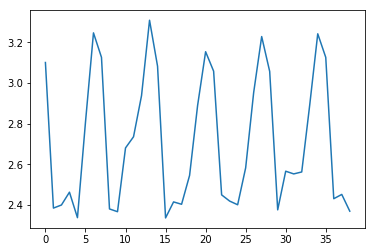

In [26]:
plt.plot(testpreds[129])

In [27]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [28]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.160293   
air_0164b9927d20bcc3_2017-04-23              1.483675   
air_0241aa3964b7f861_2017-04-23              2.426901   
air_0328696196e46f18_2017-04-23              2.109901   
air_034a3d5b40d5b1b1_2017-04-23              3.429954   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   7.673678  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.409120  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23  10.323733  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.247426  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  29.875234

In [29]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [30]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [31]:
submission.to_csv("../submission/3001eb_lgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')